# EEG Classification Notebook with Kalman Filter

Here we classify the EEG signal using a CNN. To generate the ground truth labels, we apply a kalman filter to the feeltrace signal, and then generate the emotion labels from this new signal.

In [1]:
# import some useful libraries

import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from scipy import signal


# model creation
import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold, KFold

# loading bar
from tqdm import tqdm

# kalman filter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


/home/bkat/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
dir = '../eeg_feeltrace' # directory containing *.csv files
# hyper parameters
window_size = 500 # must be an int in milliseconds
overlap = 0.0 # overlap %
subject_num = 16 # which subject to choose [1-16]
k_fold = 5 # k for k fold validation
apply_kf = False # apply kalman filter
label_type = 'angle' # 'angle' or 'pos' or 'both'
num_classes = 3 if label_type != 'both' else 9 # number of classes to discretize the labels into
num_features = 64 # eeg feature size
classifier_learning_rate = 1e-3 # adam learning rate
classifier_train_epochs = 30 # train classifier duration
classifier_hidden = 8 # classifier parameter, the larger the more complicated the model

In [3]:
# functions for preprocessing dataset
# The features are 5x64x64 images (Channel,Height,Width)

def load_dataset(dir = 'feeltrace', subject_num = 5):
    # choose the subject
    subject_data_files = glob.glob(os.path.join(dir, 'eeg_ft_*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.csv')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    eeg_ft = subject_data_files[subject_num-1]

    print(f"Chosen subject: {eeg_ft}")
    
    data_signal = pd.read_csv(eeg_ft) # read the Nx(1+1+64) data for a single subject
    # return signal
    return data_signal

def generate_label(eeg_ft, split_size=100, k=5, label_type='angle', num_classes=3, kf=False, overlap=0.0):

    # split into windows (with overlap %)
    dataset = [eeg_ft[x : x + split_size] for x in range(0, len(eeg_ft), int(split_size * (1.0-overlap)))]
    dataset = [x for x in dataset if len(x) == split_size] # remove last windows if they are smaller than the rest

    if label_type != 'both':
        labels, raw_label = get_label(dataset, n_labels=num_classes, label_type=label_type, kf=kf, dt=split_size/1000) # (N, 1)
    else:
        labels, raw_label = get_combined_label(dataset, n_labels=int(np.sqrt(num_classes))) # (N, 1)

    dataset = generate_eeg_features(dataset)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)

    print(f"EEG feature shape (N, freq_bands, channels, channels):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k) # split data into train/test indices using kFold validation
    return dataset, labels, indices, raw_label


def apply_kalman(raw_label, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,1.]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(raw_label)
    for i,m in enumerate(raw_label):
        kf.predict() # predict
        kf.update(m) # measure
        x = np.clip(kf.x[0], 0,1)
        kf_signal[i] = x
    return kf_signal


def get_label(data, n_labels=3, label_type='angle', kf=False, dt=1e-3):
    if label_type == 'angle':
        labels = stress_2_angle(np.vstack([x[:,1].T for x in data])) # angle/slope mapped to [0,1] in a time window
    elif label_type == 'pos':
        labels = np.vstack([x[:,1].mean() for x in data]) # mean value within the time window
    else:
        labels = stress_2_accumulator(np.vstack([x[:,1].T for x in data])) # accumulator mapped to [0,1] in a time window

    if kf:
        labels = apply_kalman(labels, dt, R=1e3, var=1e3, p=1e3)
        
    label_dist = stress_2_label(labels, n_labels=n_labels).squeeze()
    return label_dist, labels.squeeze()

def get_combined_label(data, n_labels=3):
    angle_labels, _ = get_label(data, n_labels=n_labels, label_type='angle') # (N, 1)
    pos_labels, _ = get_label(data, n_labels=n_labels, label_type='pos') # (N, 1)

    labels = [x for x in range(n_labels)]
    labels_dict =  {(a, b) : n_labels*a+b for a in labels for b in labels} # cartesian product
    combined_labels = [labels_dict[(pos, angle)] for (pos, angle) in zip(pos_labels, angle_labels)]
    return np.array(combined_labels)


def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

def stress_2_angle(stress_windows):
    '''
    do a linear least squares fit in the time window
    stress_window: (N_samples, time_window)
    '''
    xvals = np.arange(stress_windows.shape[-1])/1e3/60 # time in (minutes)
    slope = np.polyfit(xvals, stress_windows.T, 1)[0] # take slope linear term # 1/s
    angle = np.arctan(slope)/ (np.pi/2) * 0.5 + 0.5 # map to [0,1]
    return angle

def stress_2_accumulator(stress_windows):
    '''
    apply an integral to the time window
    stress_window: (N_samples, time_window)
    '''
    max_area = stress_windows.shape[-1]
    xvals = np.arange(stress_windows.shape[-1]) # time in (ms)
    integral = np.trapz(stress_windows, x=xvals)
    return integral/max_area # map to [0,1]

def split_dataset(labels, k=5, strat=True):
    '''
    split the features and labels into k groups for k fold validation
    we use StratifiedKFold to ensure that the class distributions within each sample is the same as the global distribution
    '''
    if strat:
        kf = StratifiedKFold(n_splits=k, shuffle=True)
    else:
        kf = KFold(n_splits=k, shuffle=True)

    # only labels are required for generating the split indices so we ignore it
    temp_features = np.zeros_like(labels)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(temp_features, labels)]
    return indices

def generate_eeg_features(dataset):
    sample_freq = 1000
    # get FFT
    psd_windows = [signal.periodogram(x[:,2:], sample_freq, window='hamming', axis=0) for x in dataset ] # get the power spectral density for each window

    # frequency bands
    bands={'alpha': (8, 12), 'beta': (12, 30), 'delta': (1, 4), 'theta': (4, 7), 'gamma': (30, 50)}
    chosen_bands = ['alpha', 'beta', 'delta', 'theta', 'gamma']
    band_freqs = [bands[x] for x in chosen_bands]

    features = []
    for window in psd_windows: # calculate the power in each band for channel for each window
        freqs, psd = window
        idx_bands = [np.logical_and(freqs >= low, freqs <= high) for low,high in band_freqs]

        freq_res = freqs[1] - freqs[0]
        # integrate across the frequency spectrum for each band
        band_powers = np.array([sp.integrate.simpson(psd[idx,:], dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        total_powers = np.array([sp.integrate.simpson(psd, dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)

        normed_powers = band_powers #/total_powers
        #diff_entropy = np.array([sp.stats.differential_entropy(x,axis=1) for x in normed_powers])
        #print(diff_entropy.shape)
        
        diff_entropy = 0.5 * np.log(normed_powers)
        # (5, 1, 64)
        # (5, 64, 1)
        diff_de = np.expand_dims(diff_entropy, axis=2) - np.expand_dims(diff_entropy, axis=1) # (5,64,64)
        diff_de = (diff_de  - diff_de.min(axis=(1,2), keepdims=True))/(diff_de.max(axis=(1,2), keepdims=True) - diff_de.min(axis=(1,2), keepdims=True))
        
        features.append(diff_de)
    return features

In [4]:
eeg_ft_signal = load_dataset(dir = dir, subject_num = subject_num)

Chosen subject: ../eeg_feeltrace/eeg_ft_15.csv


In [5]:
_, _, _, kf_raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=True, overlap=overlap)
eeg_features, labels, indices, raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=False, overlap=overlap)
print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


fsize = 30

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label, alpha=0.7, color='seagreen', label=label_type)
# axes.scatter(np.arange(len(labels)), kf_raw_label, alpha=0.7, color='pink', label='kf-'+label_type )
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()

EEG feature shape (N, freq_bands, channels, channels):  (1001, 5, 64, 64)
label set shape (N,):  (1001,)
EEG feature shape (N, freq_bands, channels, channels):  (1001, 5, 64, 64)
label set shape (N,):  (1001,)
Label class bincount: [237 559 205]


(1001, 5, 64, 64)
0


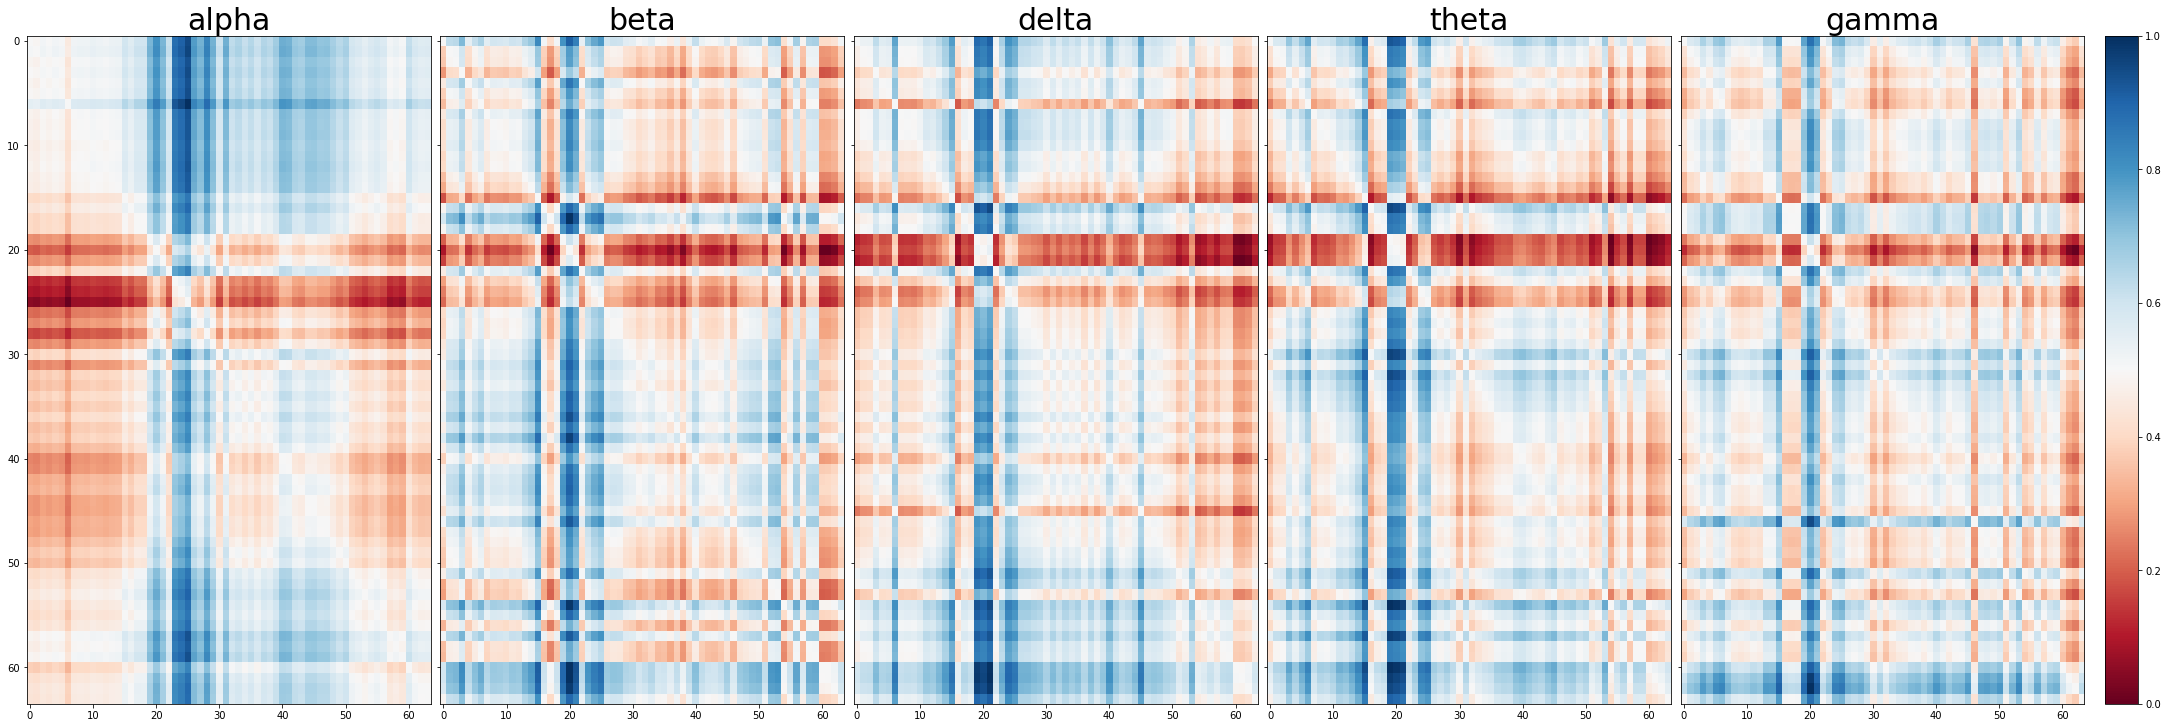

1


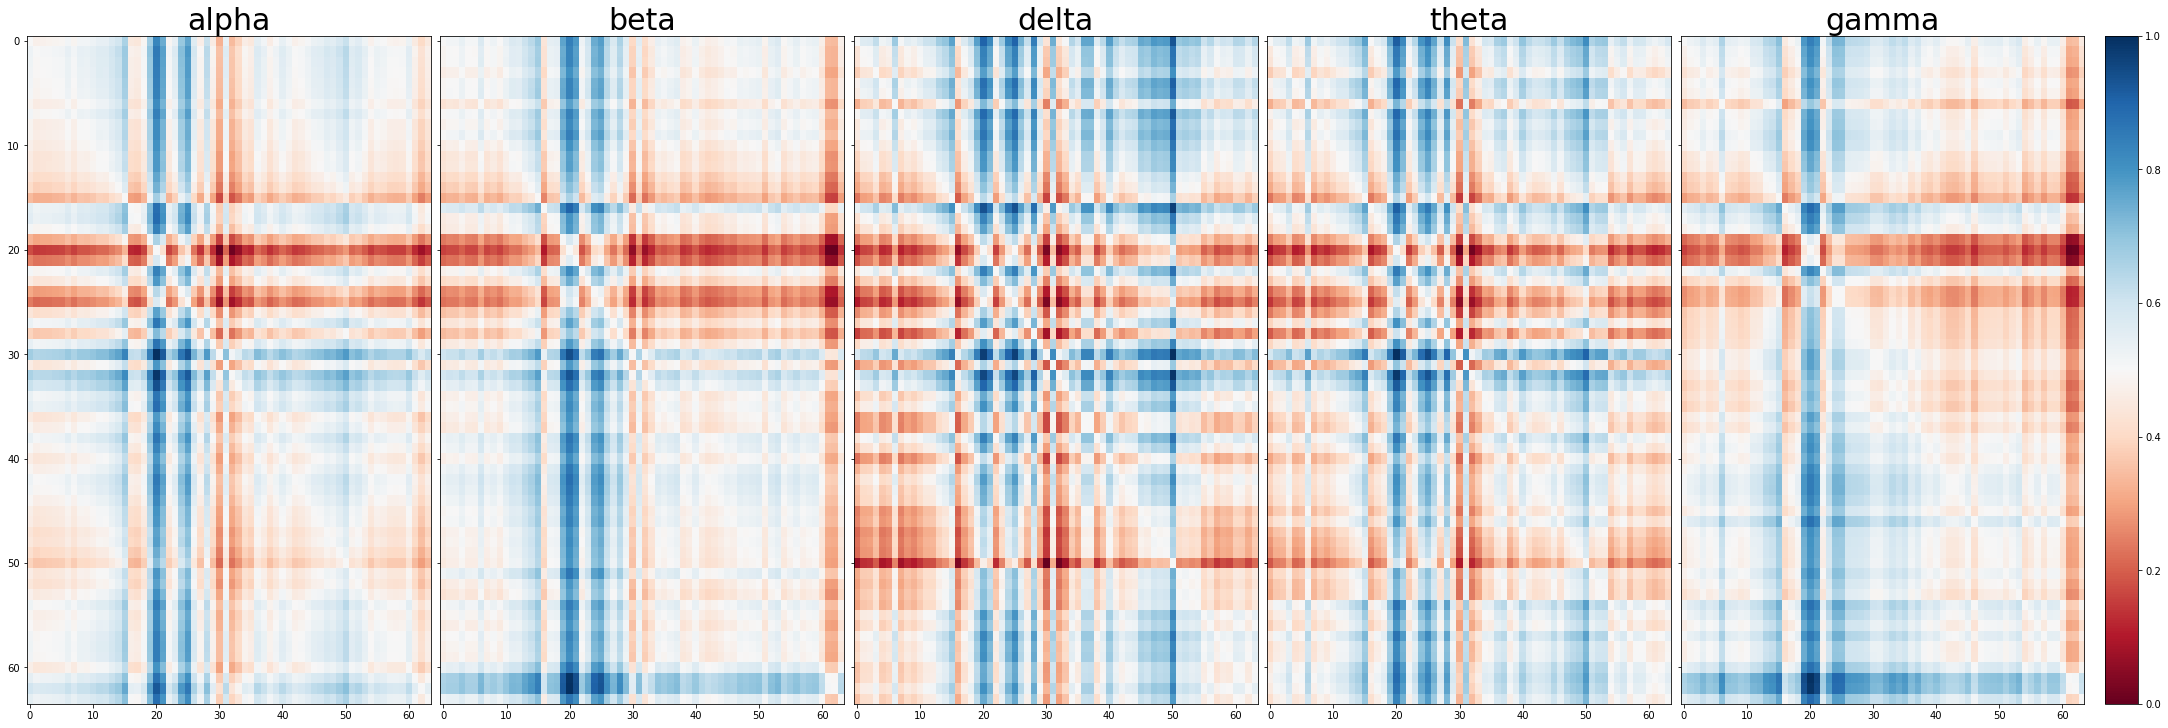

1


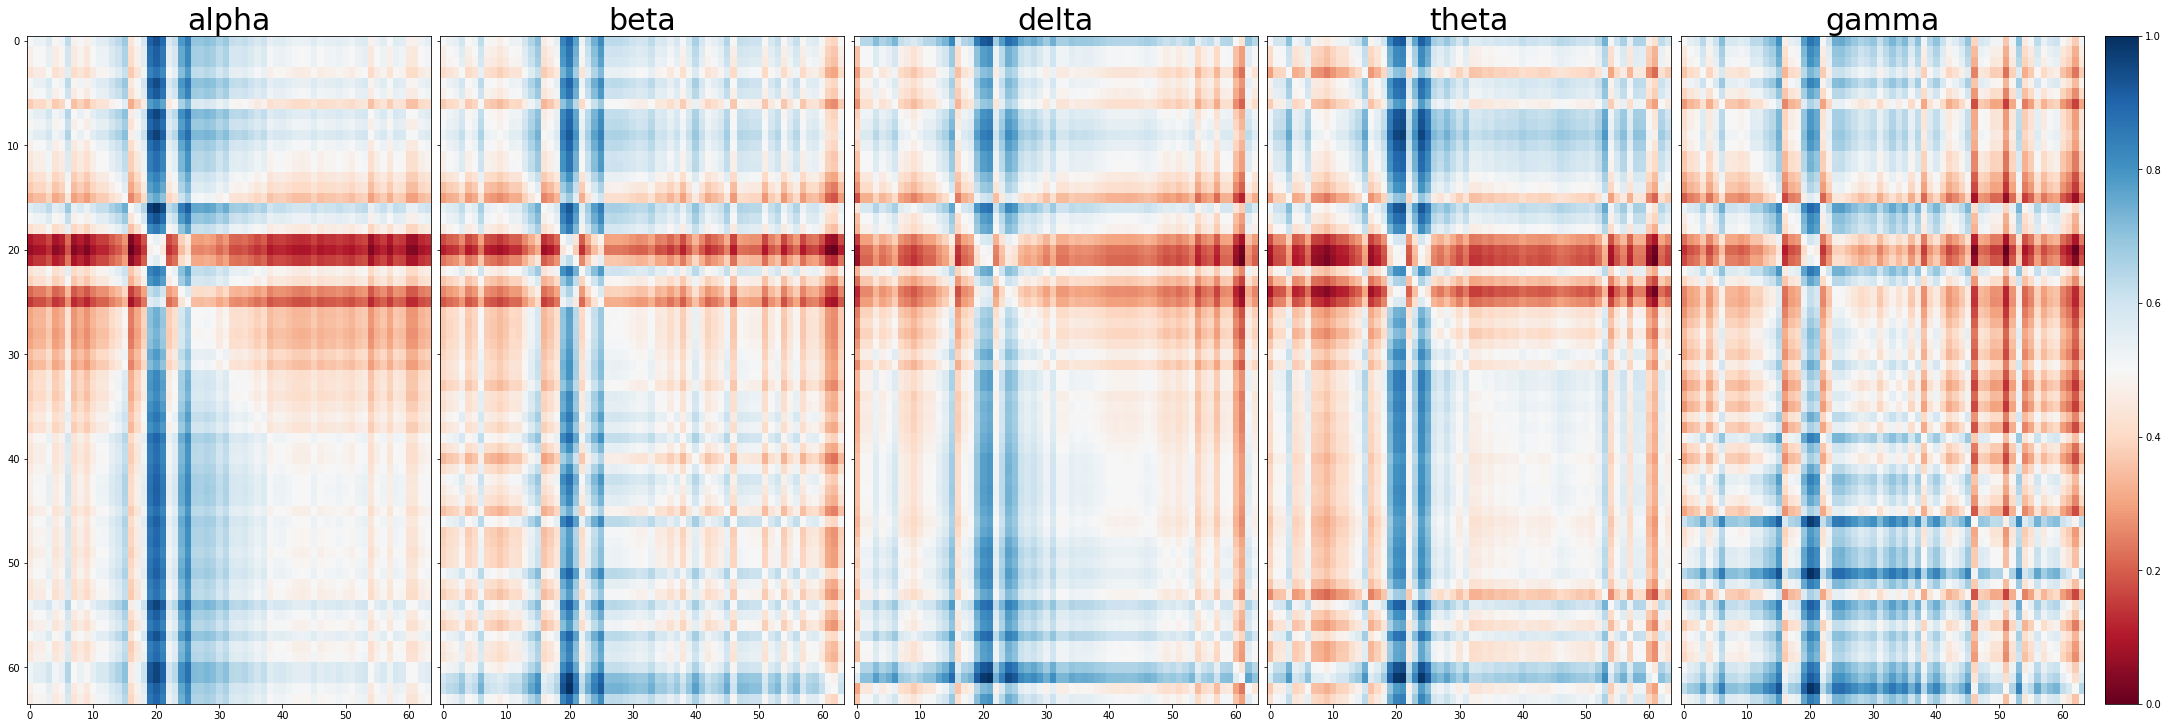

1


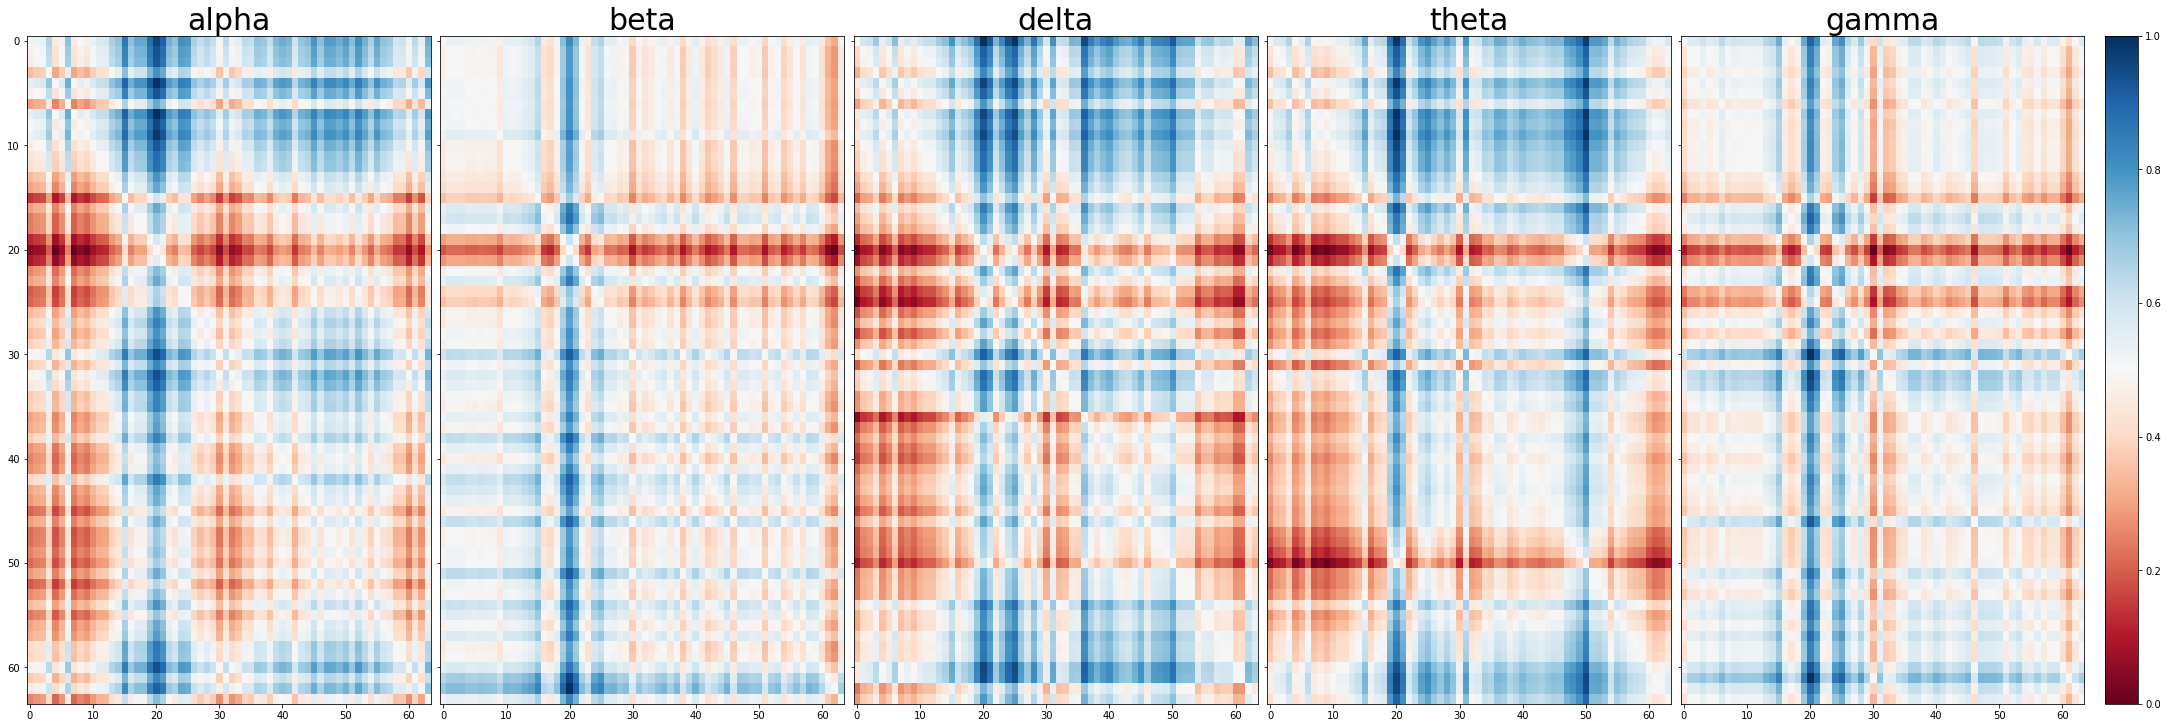

1


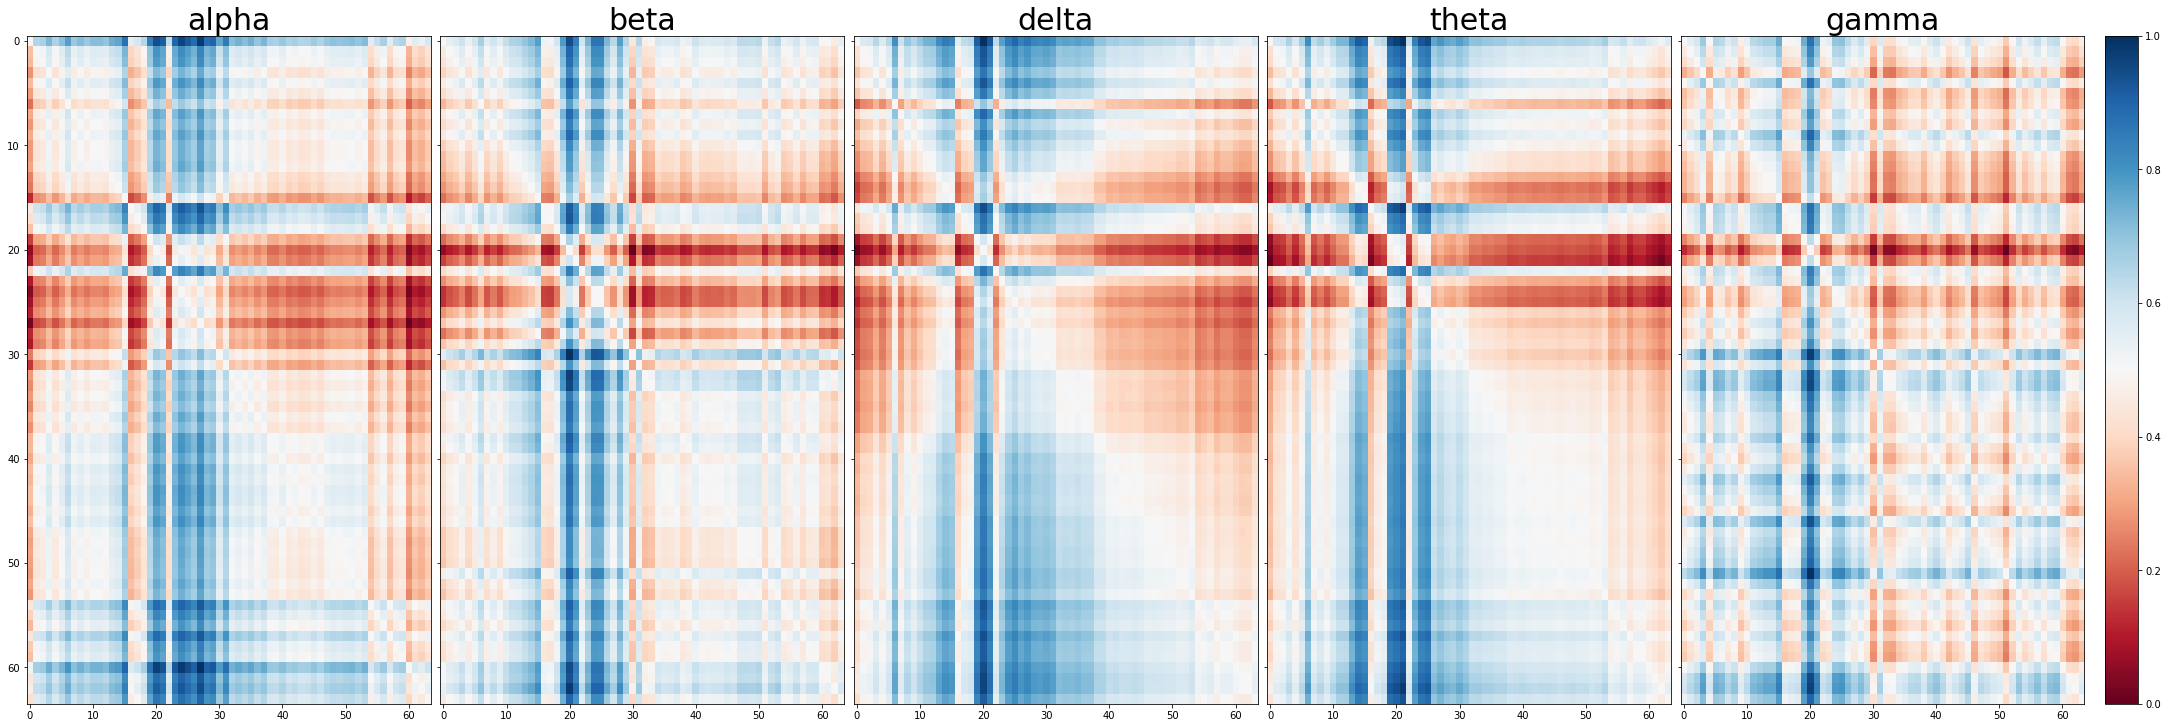

0


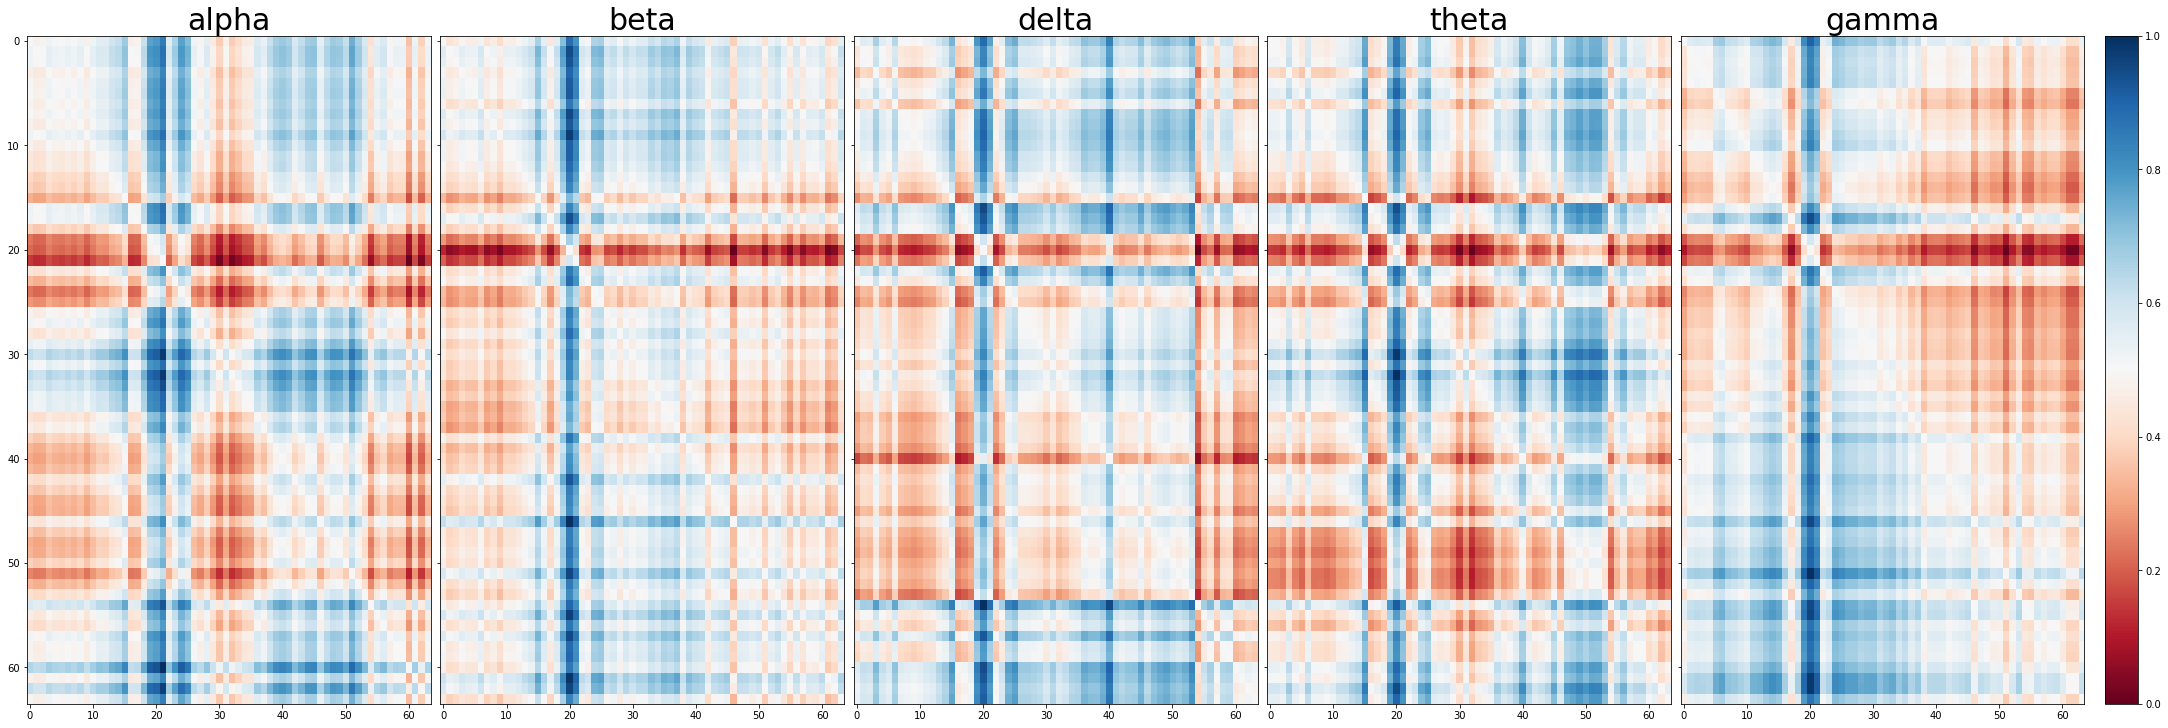

1


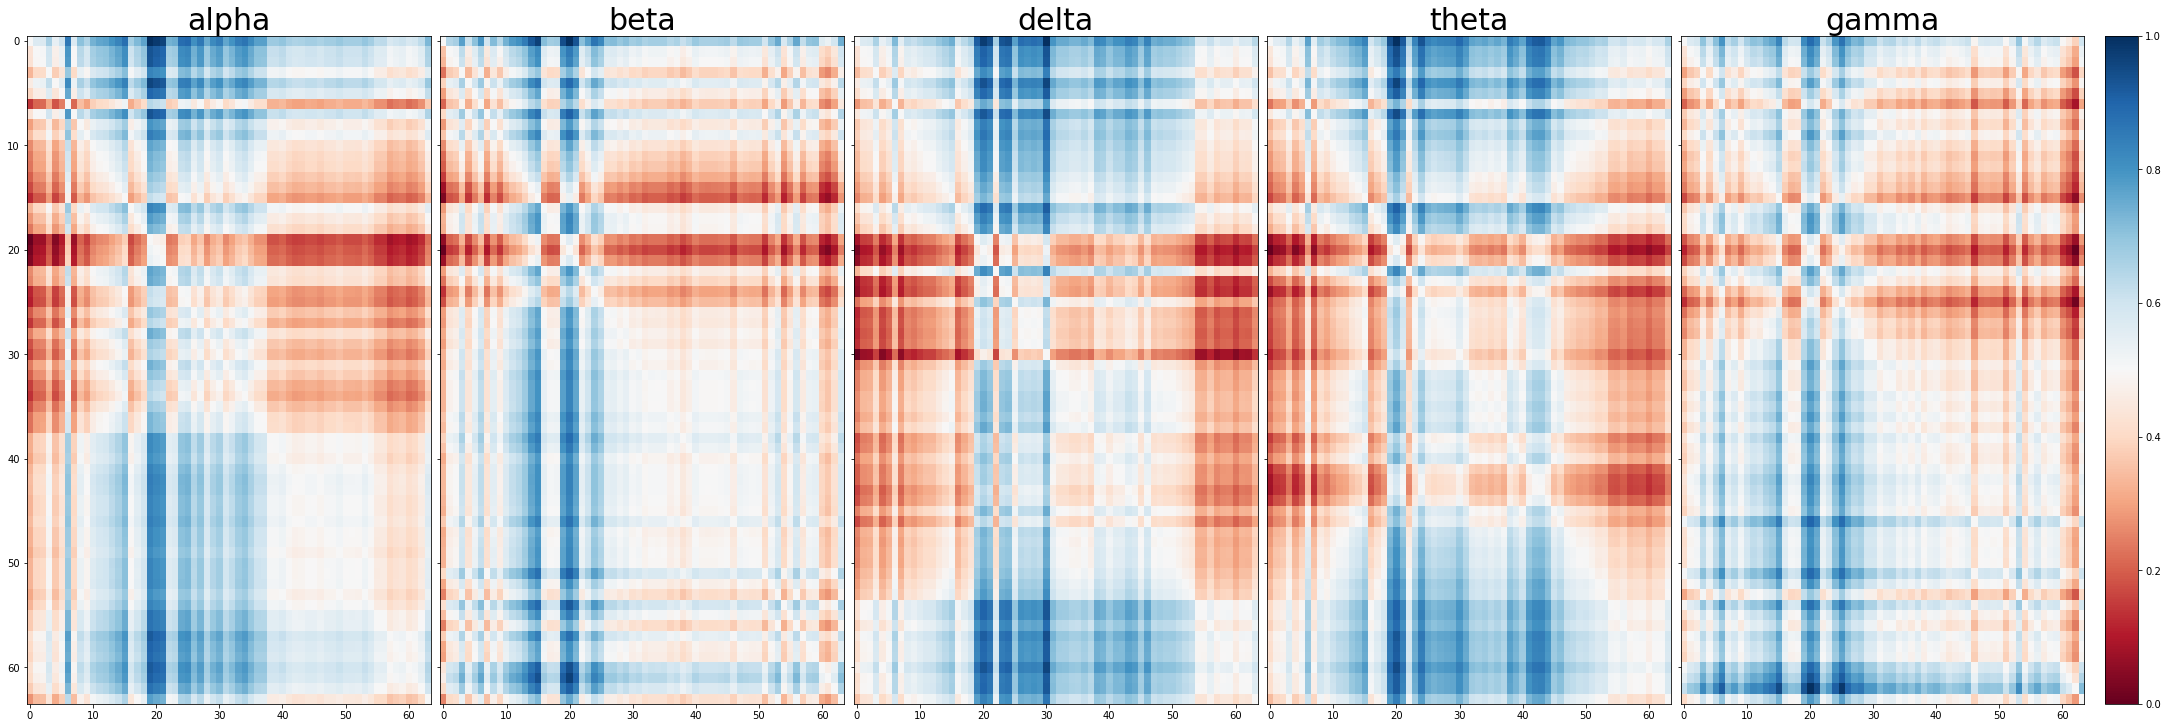

1


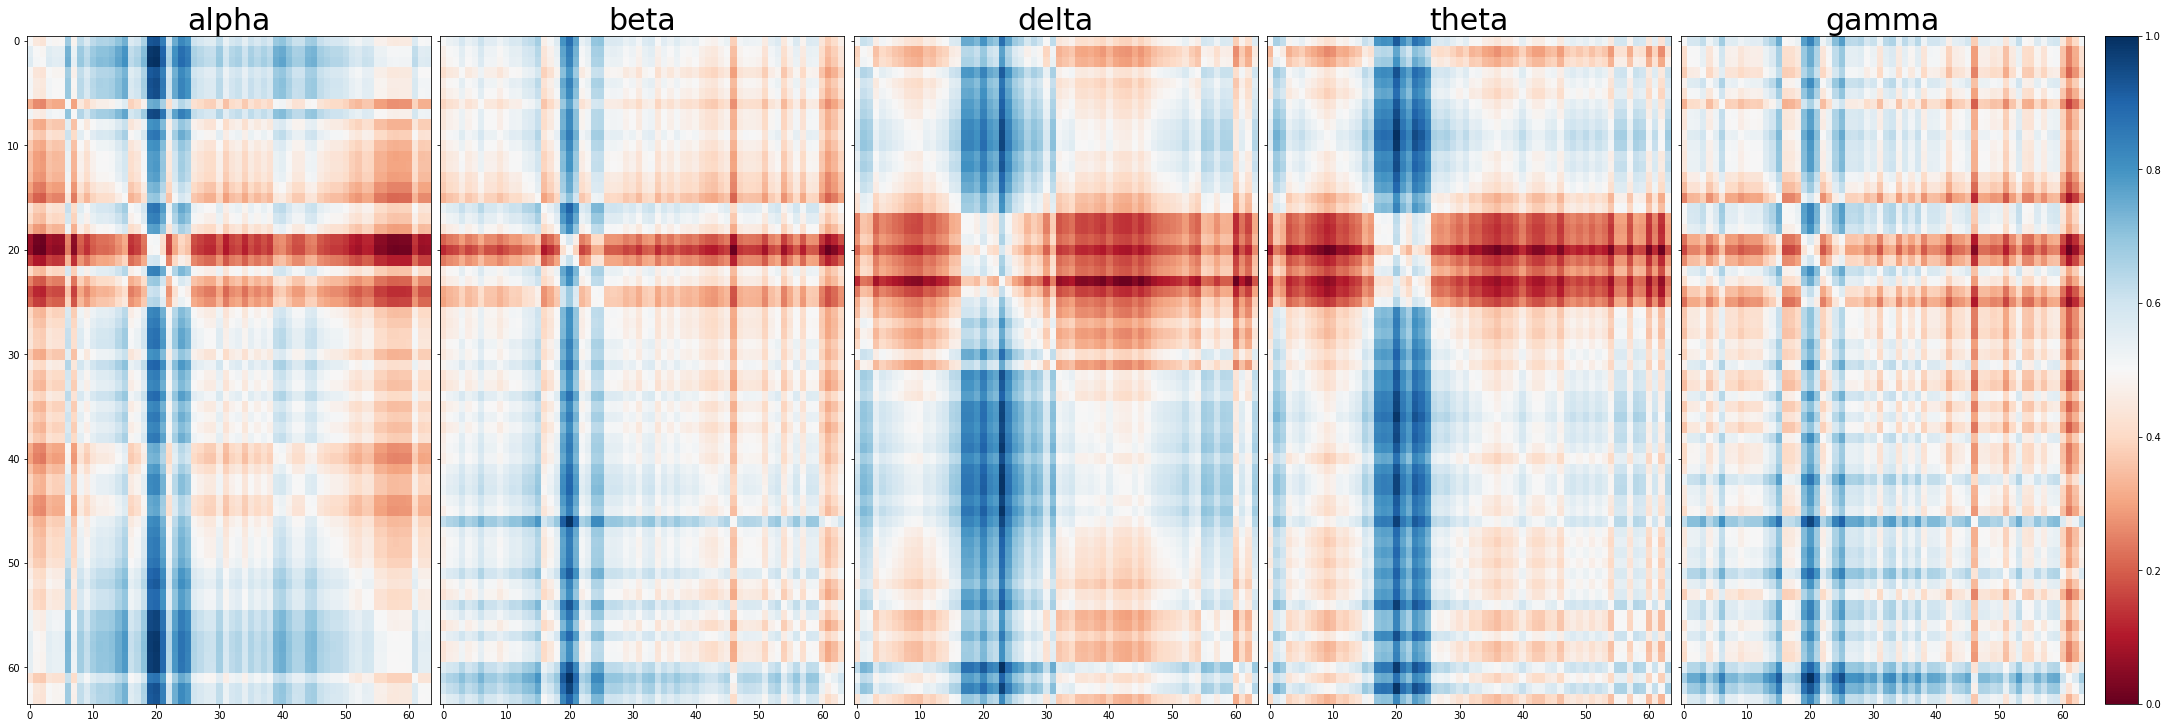

2


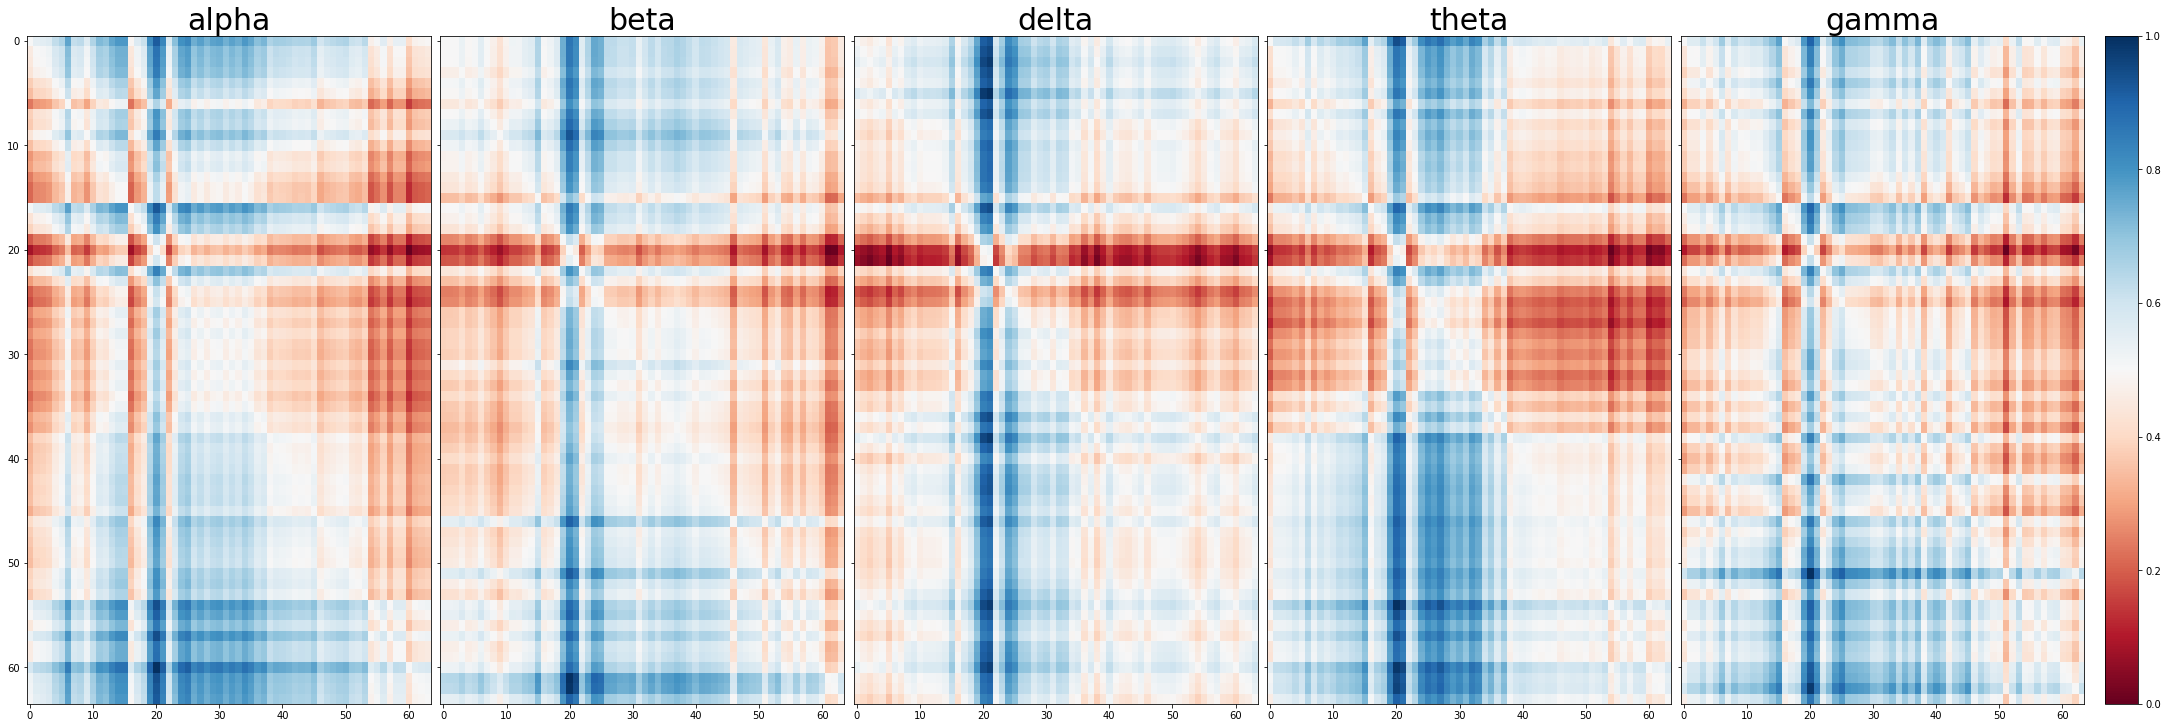

2


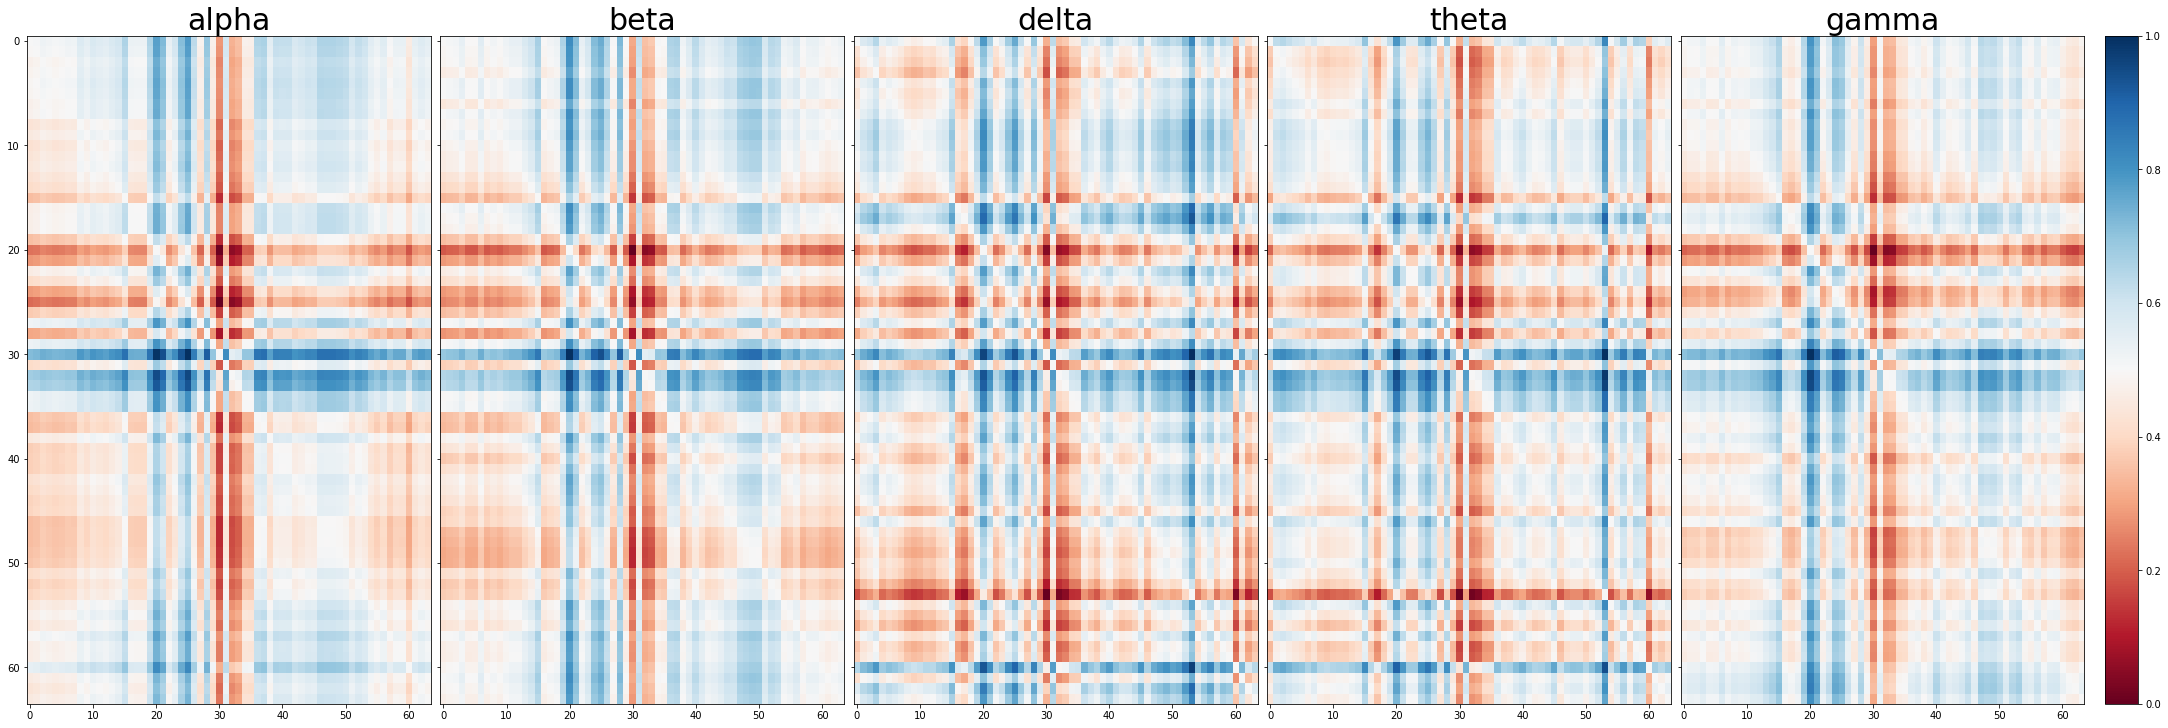

In [6]:
print(eeg_features.shape)

fsize = 30
chosen_bands = ['alpha', 'beta', 'delta', 'theta', 'gamma']
for j in np.random.randint(0, len(eeg_features), 10):
    fig, axes = plt.subplots(figsize=(30,10), nrows=1, ncols=5, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
    print(labels[j])
    for i in range(5):
        im = axes[i].imshow(eeg_features[j][i,:,:],interpolation=None, vmin=0, vmax=1, cmap="RdBu")
        axes[i].set_aspect('auto')
        axes[i].set_title(chosen_bands[i], fontsize=fsize)
    plt.colorbar(im)
    plt.show()

In [7]:
# eeg_features, labels, indices, raw_label = generate_regression_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, kf=apply_kf)
# #print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


# fsize = 30

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,0], alpha=0.7, color='seagreen', label='position')
# axes.scatter(np.arange(len(labels)), labels[:,0], alpha=0.7, color='slateblue', label='kf-position')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,1], alpha=0.7, color='pink', label='angle')
# axes.scatter(np.arange(len(labels)), labels[:,1], alpha=0.7, color='gray', label='kf-angle')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()



In [ ]:
fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
n_bins = 100
fsize = 30
lsize = 22

axes.hist(kf_raw_label, histtype='stepfilled', alpha=0.7, bins=n_bins, color='slateblue', label='position')
axes.grid('on', linestyle='--')
axes.set_aspect('auto')
axes.set_title('Emotion as change angle', fontsize=fsize)
axes.set_xlabel('change angle', fontsize=lsize)


fig.supylabel('Count', fontsize=fsize)
plt.show()


## EEG Classifier and Training Function

In [16]:
class classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=5):
        super(classifier, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same', padding_mode='circular'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64* 64 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, self.n_classes))
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        'Initialization'
        self.x = features # (N, eeg_feature_size, 64)
        self.labels = labels # (N, 1)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index]).float() # (eeg_feature_size, 64, 64)
        y = torch.from_numpy(np.array(self.labels[index])).long() # feel trace labels int value [0,n_labels]
        return x, y


def train_classifier(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None,  label_smoothing=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_labels = labels
    
    # get the weights of each class as 1/occurrence
    train_class_weight = np.bincount(train_labels, minlength=num_classes)
    print(f"Train label distribution: {train_class_weight}")
    train_class_weight = 1/train_class_weight
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    
    # sampler, weighted by the inverse of the occurrence
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},')
        
    return train_metrics

## Training Classifier Loop

Training k=0
Training Classifier!
Train label distribution: [189 447 164]


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Epoch:1,
Train Loss:1.9247163534164429,
Train Accuracy:0.3325892857142857,
Train Recall: 0.32697283345960043,
Train precision: 0.1534091228287657,
Train F1-Score:0.19253487929096597,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:2,
Train Loss:1.1190308332443237,
Train Accuracy:0.3828125,
Train Recall: 0.3333333333333333,
Train precision: 0.12760416666666669,
Train F1-Score:0.1834671799163381,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:3,
Train Loss:1.0983226299285889,
Train Accuracy:0.33482142857142855,
Train Recall: 0.33963665933331855,
Train precision: 0.16474339152043146,
Train F1-Score:0.19052280749566403,


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch:4,
Train Loss:1.098541259765625,
Train Accuracy:0.32589285714285715,
Train Recall: 0.3333333333333333,
Train precision: 0.1086309523809524,
Train F1-Score:0.16357346037492776,


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch:5,
Train Loss:1.0978831052780151,
Train Accuracy:0.3627232142857143,
Train Recall: 0.3345543345543346,
Train precision: 0.16829244000749907,
Train F1-Score:0.17906612862701343,


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch:6,
Train Loss:1.095072865486145,
Train Accuracy:0.39285714285714285,
Train Recall: 0.36750621682769946,
Train precision: 0.28623352337861674,
Train F1-Score:0.2616241531685034,


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch:7,
Train Loss:1.09386146068573,
Train Accuracy:0.3515625,
Train Recall: 0.36127542804561436,
Train precision: 0.21072560081330655,
Train F1-Score:0.21395979325609363,


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch:8,
Train Loss:1.0945594310760498,
Train Accuracy:0.3950892857142857,
Train Recall: 0.391418648070673,
Train precision: 0.2819177092224582,
Train F1-Score:0.2946381083205955,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:9,
Train Loss:1.0814988613128662,
Train Accuracy:0.45982142857142855,
Train Recall: 0.4694591743007234,
Train precision: 0.5006142067716425,
Train F1-Score:0.426943678163825,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:10,
Train Loss:1.0691274404525757,
Train Accuracy:0.4296875,
Train Recall: 0.4251798419234887,
Train precision: 0.48090047454368856,
Train F1-Score:0.3759969292024871,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:11,
Train Loss:1.060006856918335,
Train Accuracy:0.4486607142857143,
Train Recall: 0.4374977297057953,
Train precision: 0.4123363572955941,
Train F1-Score:0.3899063128742903,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:12,
Train Loss:1.0421463251113892,
Train Accuracy:0.48549107142857145,
Train Recall: 0.4889151798668017,
Train precision: 0.5646992022273529,
Train F1-Score:0.4283118403753181,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:13,
Train Loss:1.0344016551971436,
Train Accuracy:0.45424107142857145,
Train Recall: 0.45350332382193564,
Train precision: 0.46852922059763935,
Train F1-Score:0.42419630624548754,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:14,
Train Loss:1.0224665403366089,
Train Accuracy:0.48325892857142855,
Train Recall: 0.4693068656135004,
Train precision: 0.5024293076739045,
Train F1-Score:0.4480289272446845,


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:15,
Train Loss:0.9972004890441895,
Train Accuracy:0.5200892857142857,
Train Recall: 0.5267730583404605,
Train precision: 0.5393622818002631,
Train F1-Score:0.5114182883781498,


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:16,
Train Loss:0.9593151211738586,
Train Accuracy:0.5513392857142857,
Train Recall: 0.5501766436815912,
Train precision: 0.5640766601212052,
Train F1-Score:0.5457216897649018,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:17,
Train Loss:0.9471117258071899,
Train Accuracy:0.5558035714285714,
Train Recall: 0.5670698627165709,
Train precision: 0.5654973145301242,
Train F1-Score:0.5511725694634333,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:18,
Train Loss:0.9092918634414673,
Train Accuracy:0.6026785714285714,
Train Recall: 0.60016966071088,
Train precision: 0.6025965273634063,
Train F1-Score:0.5959930711807292,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:19,
Train Loss:0.9295249581336975,
Train Accuracy:0.5647321428571429,
Train Recall: 0.5707054544051581,
Train precision: 0.5664593284981215,
Train F1-Score:0.5519229747755451,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:20,
Train Loss:0.9133386611938477,
Train Accuracy:0.5825892857142857,
Train Recall: 0.5758305408098204,
Train precision: 0.597814690682348,
Train F1-Score:0.5484959347870084,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:21,
Train Loss:0.8981465697288513,
Train Accuracy:0.5870535714285714,
Train Recall: 0.5897112339565885,
Train precision: 0.5993306243130626,
Train F1-Score:0.5846971556436155,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:22,
Train Loss:0.8329166769981384,
Train Accuracy:0.6261160714285714,
Train Recall: 0.6297282959821142,
Train precision: 0.6320698282150475,
Train F1-Score:0.6226058441904124,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:23,
Train Loss:0.81172114610672,
Train Accuracy:0.6305803571428571,
Train Recall: 0.634052624081173,
Train precision: 0.6348121052146765,
Train F1-Score:0.6239933106475622,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:24,
Train Loss:0.756680965423584,
Train Accuracy:0.6674107142857143,
Train Recall: 0.6659116718550105,
Train precision: 0.6749713927495258,
Train F1-Score:0.6615806619197563,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:25,
Train Loss:0.7524917721748352,
Train Accuracy:0.6651785714285714,
Train Recall: 0.6676167868302095,
Train precision: 0.6723911338245162,
Train F1-Score:0.6605952322467897,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:26,
Train Loss:0.7232290506362915,
Train Accuracy:0.703125,
Train Recall: 0.6936433151412539,
Train precision: 0.6909219809974063,
Train F1-Score:0.6873131720520613,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:27,
Train Loss:0.7266172766685486,
Train Accuracy:0.7165178571428571,
Train Recall: 0.7164976309511611,
Train precision: 0.7141181338185617,
Train F1-Score:0.7086400019307605,


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch:28,
Train Loss:0.6813000440597534,
Train Accuracy:0.6975446428571429,
Train Recall: 0.7007397677388457,
Train precision: 0.6965550255881164,
Train F1-Score:0.6919445665408327,


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch:29,
Train Loss:0.6539397835731506,
Train Accuracy:0.75,
Train Recall: 0.7509467038085995,
Train precision: 0.7550585498771442,
Train F1-Score:0.744108680922805,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:30,
Train Loss:0.6488186717033386,
Train Accuracy:0.7388392857142857,
Train Recall: 0.72774289088894,
Train precision: 0.7375788368800448,
Train F1-Score:0.7277061309073989,
Test label distribution: [ 48 112  41]
Precision: 0.41299696472110264
Recall: 0.41400503290747187
F1-Score: 0.3997860957244958
Base line F1-Score: 0.23855165069222575
Accuracy: 0.43283582089552236
Metrics:
              precision    recall  f1-score   support

           0       0.29      0.35      0.32        48
           1       0.69      0.47      0.56       112
           2       0.26      0.41      0.32        41

    accuracy                           0.43       201
   macro avg       0.41      0.41      0.40       201
weighted avg       0.51      0.43      0.45       201



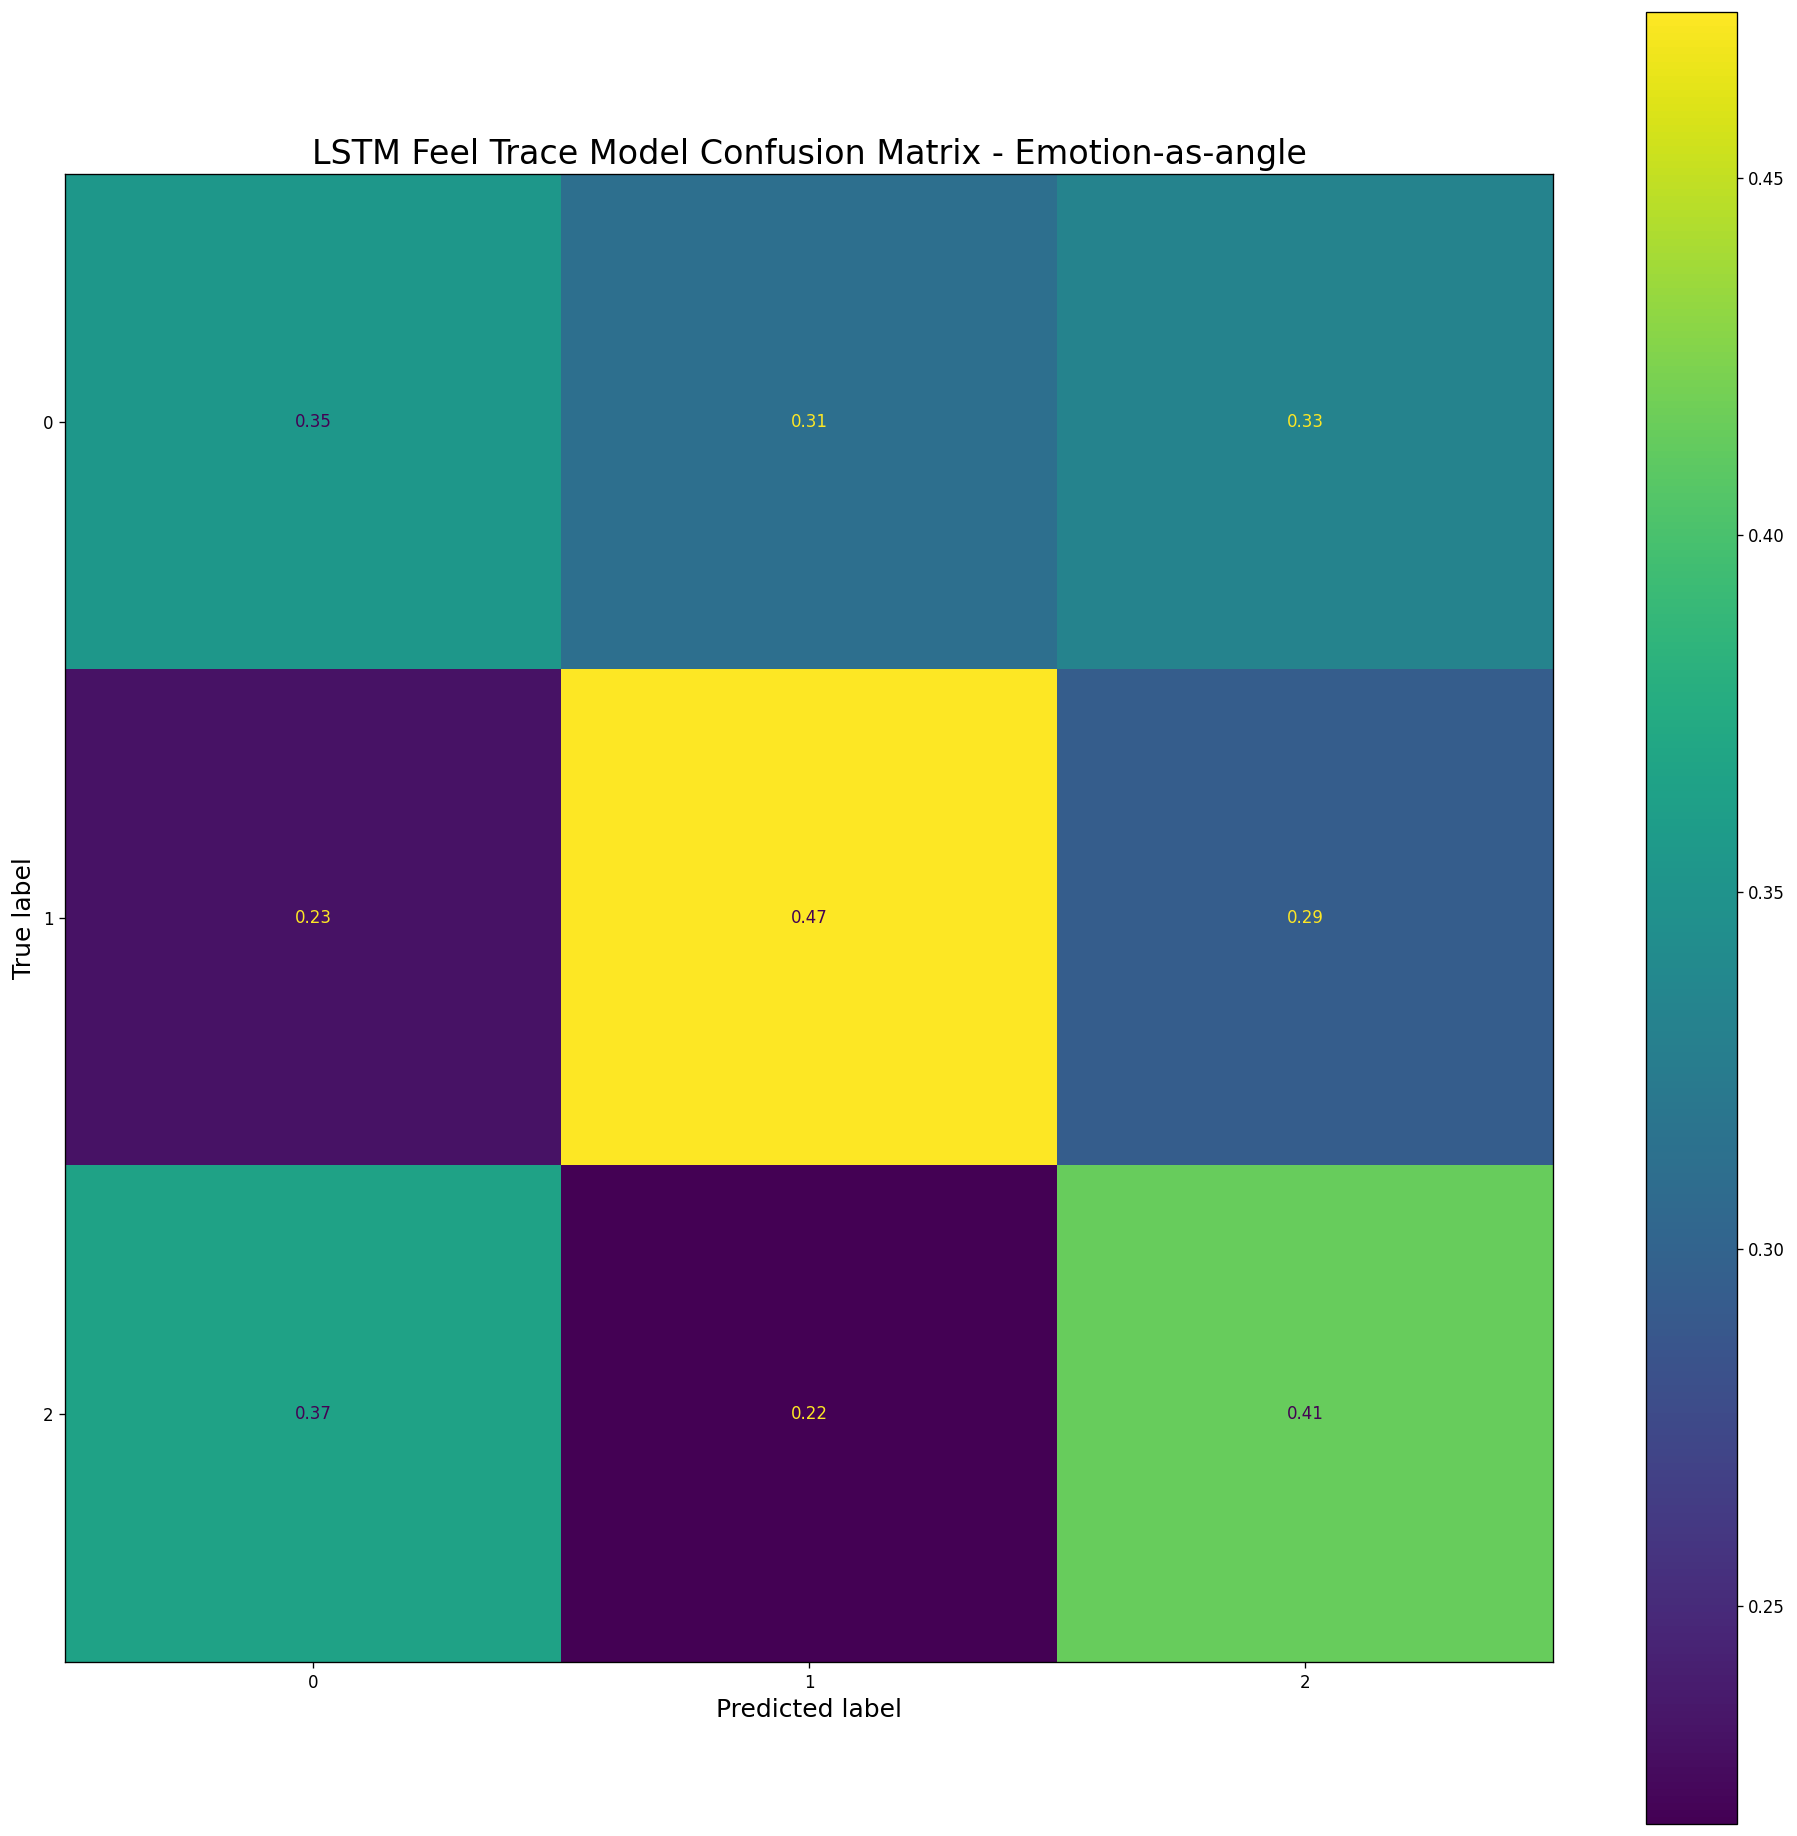

Training k=1
Training Classifier!
Train label distribution: [190 447 164]


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch:1,
Train Loss:1.178924560546875,
Train Accuracy:0.3132440476190476,
Train Recall: 0.3285289026568096,
Train precision: 0.13887917637917638,
Train F1-Score:0.17746869195208517,


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch:2,
Train Loss:1.0976641178131104,
Train Accuracy:0.34226190476190477,
Train Recall: 0.3333333333333333,
Train precision: 0.1140873015873016,
Train F1-Score:0.16988625268097907,


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch:3,
Train Loss:1.0974441766738892,
Train Accuracy:0.349803841991342,
Train Recall: 0.36132887896451005,
Train precision: 0.23436210677553024,
Train F1-Score:0.25461577432884314,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:4,
Train Loss:1.0876491069793701,
Train Accuracy:0.42863906926406925,
Train Recall: 0.41465337277352615,
Train precision: 0.4338521256611742,
Train F1-Score:0.3571382603550073,


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Epoch:5,
Train Loss:1.0874501466751099,
Train Accuracy:0.35190070346320346,
Train Recall: 0.3662150955920067,
Train precision: 0.43064436264229383,
Train F1-Score:0.2679622028111986,


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch:6,
Train Loss:1.0696189403533936,
Train Accuracy:0.43489583333333337,
Train Recall: 0.43827664126955707,
Train precision: 0.49393085841748346,
Train F1-Score:0.388537727109824,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:7,
Train Loss:1.0596731901168823,
Train Accuracy:0.4342194264069264,
Train Recall: 0.4422360255982355,
Train precision: 0.4667005203867742,
Train F1-Score:0.4135673201336723,


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch:8,
Train Loss:1.034049153327942,
Train Accuracy:0.48792613636363635,
Train Recall: 0.48771336782313696,
Train precision: 0.5020336263952759,
Train F1-Score:0.47667977091006314,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:9,
Train Loss:1.0020672082901,
Train Accuracy:0.4979707792207792,
Train Recall: 0.4915700847402914,
Train precision: 0.4962422780316487,
Train F1-Score:0.48522367613794687,


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Epoch:10,
Train Loss:0.9820870161056519,
Train Accuracy:0.5166734307359307,
Train Recall: 0.5233536919742219,
Train precision: 0.5898850177985625,
Train F1-Score:0.46702552161175565,


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Epoch:11,
Train Loss:0.9472668766975403,
Train Accuracy:0.5578327922077922,
Train Recall: 0.5570910541313271,
Train precision: 0.5778062292176303,
Train F1-Score:0.5434488525574342,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:12,
Train Loss:0.9144592881202698,
Train Accuracy:0.5843479437229437,
Train Recall: 0.5717415624249572,
Train precision: 0.5928727353130832,
Train F1-Score:0.5641542038544315,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:13,
Train Loss:0.8976711630821228,
Train Accuracy:0.5519818722943722,
Train Recall: 0.5568314639713057,
Train precision: 0.5873031351086462,
Train F1-Score:0.5247715248450433,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:14,
Train Loss:0.8875573873519897,
Train Accuracy:0.5592194264069265,
Train Recall: 0.5528937555278033,
Train precision: 0.5717473662486335,
Train F1-Score:0.5229907161489974,


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch:15,
Train Loss:0.8229607939720154,
Train Accuracy:0.6476934523809524,
Train Recall: 0.6531087378729,
Train precision: 0.6691535432191752,
Train F1-Score:0.64483875063144,


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch:16,
Train Loss:0.7919307947158813,
Train Accuracy:0.6433644480519481,
Train Recall: 0.6410238463054206,
Train precision: 0.6455707870205286,
Train F1-Score:0.6270010280966926,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:17,
Train Loss:0.7828644514083862,
Train Accuracy:0.6375135281385281,
Train Recall: 0.6424717475094784,
Train precision: 0.6404249292106983,
Train F1-Score:0.6333857691080176,


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch:18,
Train Loss:0.7404393553733826,
Train Accuracy:0.6775568181818182,
Train Recall: 0.669906264857232,
Train precision: 0.6866373487981013,
Train F1-Score:0.6656818090492266,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:19,
Train Loss:0.7329864501953125,
Train Accuracy:0.7029558982683983,
Train Recall: 0.7025181832249918,
Train precision: 0.7076895595855746,
Train F1-Score:0.6986936211121453,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:20,
Train Loss:0.7359768748283386,
Train Accuracy:0.6843885281385281,
Train Recall: 0.6822306345699687,
Train precision: 0.6910418817482752,
Train F1-Score:0.6725992800015733,


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch:21,
Train Loss:0.7341852188110352,
Train Accuracy:0.6801948051948052,
Train Recall: 0.6730588378462716,
Train precision: 0.6731594865372937,
Train F1-Score:0.6574726835882736,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:22,
Train Loss:0.6689115762710571,
Train Accuracy:0.7068452380952381,
Train Recall: 0.7053533952843847,
Train precision: 0.7085488901305286,
Train F1-Score:0.6990079684191747,


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:23,
Train Loss:0.674117386341095,
Train Accuracy:0.7156385281385281,
Train Recall: 0.729507837833904,
Train precision: 0.7222967081579226,
Train F1-Score:0.7147285301036101,


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Epoch:24,
Train Loss:0.6277388334274292,
Train Accuracy:0.7483089826839827,
Train Recall: 0.7478210754202802,
Train precision: 0.7538560243404229,
Train F1-Score:0.7461177793126776,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:25,
Train Loss:0.5645826458930969,
Train Accuracy:0.7729978354978355,
Train Recall: 0.770368464127935,
Train precision: 0.7691268420764532,
Train F1-Score:0.7670510791076793,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:26,
Train Loss:0.6038872003555298,
Train Accuracy:0.7607210497835498,
Train Recall: 0.7537890545709799,
Train precision: 0.7619082846043408,
Train F1-Score:0.749017041472478,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:27,
Train Loss:0.5807885527610779,
Train Accuracy:0.7499661796536797,
Train Recall: 0.7493482112707198,
Train precision: 0.7610444231190786,
Train F1-Score:0.7461093041459839,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:28,
Train Loss:0.5611575245857239,
Train Accuracy:0.7488501082251082,
Train Recall: 0.743784861888263,
Train precision: 0.754382319249552,
Train F1-Score:0.7406350300226141,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:29,
Train Loss:0.5047078728675842,
Train Accuracy:0.8087121212121212,
Train Recall: 0.8067736301082457,
Train precision: 0.8078484649521867,
Train F1-Score:0.8036080132405944,


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch:30,
Train Loss:0.4924526810646057,
Train Accuracy:0.8205830627705628,
Train Recall: 0.8174417228228599,
Train precision: 0.8216820901924821,
Train F1-Score:0.8142851325886056,
Test label distribution: [ 47 112  41]
Precision: 0.3530780441228203
Recall: 0.354727308671263
F1-Score: 0.3456360708534622
Base line F1-Score: 0.23931623931623933
Accuracy: 0.39
Metrics:
              precision    recall  f1-score   support

           0       0.24      0.23      0.24        47
           1       0.59      0.46      0.52       112
           2       0.22      0.37      0.28        41

    accuracy                           0.39       200
   macro avg       0.35      0.35      0.35       200
weighted avg       0.43      0.39      0.40       200



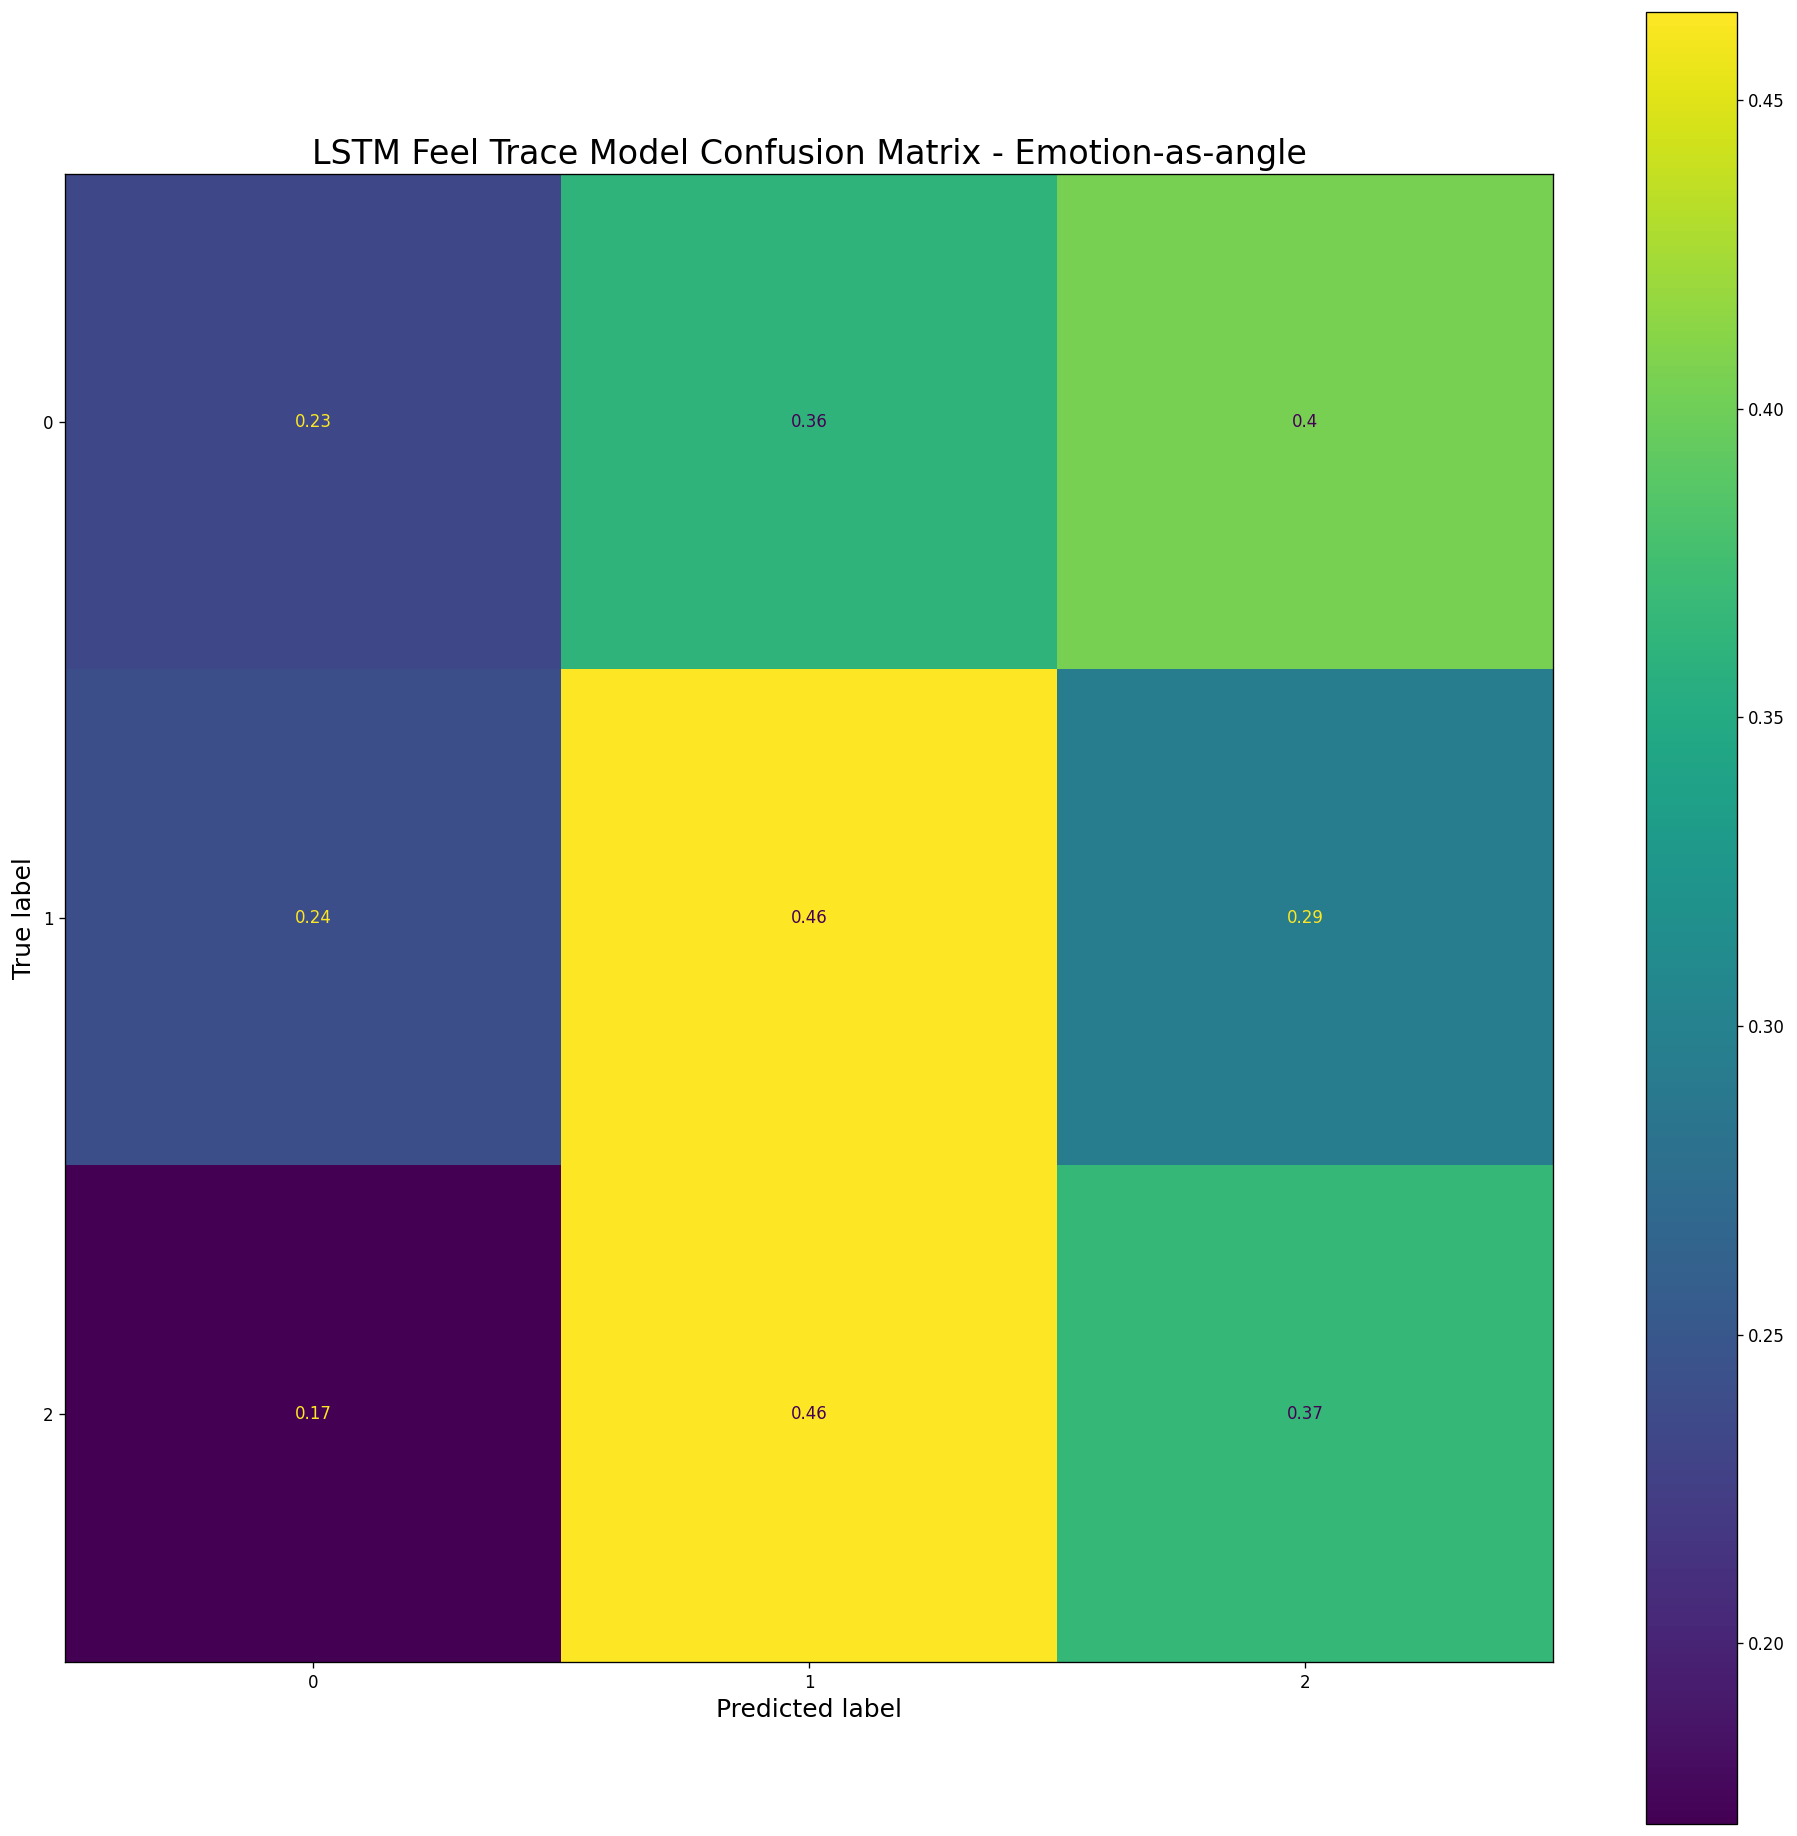

Training k=2
Training Classifier!
Train label distribution: [190 447 164]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch:1,
Train Loss:1.6536874771118164,
Train Accuracy:0.36431277056277056,
Train Recall: 0.332395342743374,
Train precision: 0.23405007142956422,
Train F1-Score:0.22154404995690638,


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:2,
Train Loss:1.1137467622756958,
Train Accuracy:0.3668154761904762,
Train Recall: 0.343947439589854,
Train precision: 0.25218077706169145,
Train F1-Score:0.26019373964865905,


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch:3,
Train Loss:1.0975931882858276,
Train Accuracy:0.36640963203463206,
Train Recall: 0.3386751325205892,
Train precision: 0.3258275010288438,
Train F1-Score:0.2802940195944649,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:4,
Train Loss:1.1123629808425903,
Train Accuracy:0.3154761904761905,
Train Recall: 0.327048328986288,
Train precision: 0.22824642661995667,
Train F1-Score:0.21633357466811226,


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch:5,
Train Loss:1.1014108657836914,
Train Accuracy:0.3301204004329005,
Train Recall: 0.32883169764134773,
Train precision: 0.2199307581372191,
Train F1-Score:0.19559841472135558,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:6,
Train Loss:1.0973787307739258,
Train Accuracy:0.37087391774891776,
Train Recall: 0.3509601124388006,
Train precision: 0.3580714475881637,
Train F1-Score:0.3256437804889024,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:7,
Train Loss:1.0932220220565796,
Train Accuracy:0.3652935606060606,
Train Recall: 0.3441458896574737,
Train precision: 0.3214098005158343,
Train F1-Score:0.24021287791694101,


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:8,
Train Loss:1.0994879007339478,
Train Accuracy:0.3465909090909091,
Train Recall: 0.3486451819785153,
Train precision: 0.15954866141859042,
Train F1-Score:0.19803340265875916,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:9,
Train Loss:1.0954115390777588,
Train Accuracy:0.36150568181818177,
Train Recall: 0.33701202092558635,
Train precision: 0.18507318840002543,
Train F1-Score:0.20016312954750068,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:10,
Train Loss:1.1028400659561157,
Train Accuracy:0.3104369588744588,
Train Recall: 0.32863408521303256,
Train precision: 0.1511676274840645,
Train F1-Score:0.15911832131303197,


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Epoch:11,
Train Loss:1.0961964130401611,
Train Accuracy:0.35247564935064934,
Train Recall: 0.3438507390832747,
Train precision: 0.26811901411353073,
Train F1-Score:0.2353294983415124,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:12,
Train Loss:1.0947465896606445,
Train Accuracy:0.36640963203463206,
Train Recall: 0.3520842005140636,
Train precision: 0.22636892298773167,
Train F1-Score:0.22364714842786876,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:13,
Train Loss:1.0940264463424683,
Train Accuracy:0.35020968614718617,
Train Recall: 0.36602013597180083,
Train precision: 0.242161724515454,
Train F1-Score:0.2821098720308614,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:14,
Train Loss:1.0920532941818237,
Train Accuracy:0.3792275432900433,
Train Recall: 0.37475777028587537,
Train precision: 0.26344812059320705,
Train F1-Score:0.27874133375388244,


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch:15,
Train Loss:1.0976283550262451,
Train Accuracy:0.33806818181818177,
Train Recall: 0.3464104096080957,
Train precision: 0.3001081154001371,
Train F1-Score:0.27487133912148287,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:16,
Train Loss:1.0936403274536133,
Train Accuracy:0.35064935064935066,
Train Recall: 0.34448909073731404,
Train precision: 0.3800511109870833,
Train F1-Score:0.2677505281827076,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:17,
Train Loss:1.090607762336731,
Train Accuracy:0.37408685064935066,
Train Recall: 0.3365037476863305,
Train precision: 0.17243761868476118,
Train F1-Score:0.19043661620281527,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:18,
Train Loss:1.0876761674880981,
Train Accuracy:0.3906926406926407,
Train Recall: 0.38178788782558637,
Train precision: 0.3025244155114978,
Train F1-Score:0.3025029045366037,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:19,
Train Loss:1.0951303243637085,
Train Accuracy:0.3303909632034632,
Train Recall: 0.3486356844608948,
Train precision: 0.24653435186940373,
Train F1-Score:0.21380666202290777,


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch:20,
Train Loss:1.0828707218170166,
Train Accuracy:0.38342126623376627,
Train Recall: 0.36165883637693735,
Train precision: 0.25086968972601403,
Train F1-Score:0.27196286305124634,


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Epoch:21,
Train Loss:1.0849848985671997,
Train Accuracy:0.36610524891774887,
Train Recall: 0.35063381180415015,
Train precision: 0.3845509619709748,
Train F1-Score:0.26641913237112885,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:22,
Train Loss:1.078955054283142,
Train Accuracy:0.4264069264069264,
Train Recall: 0.42838225296718196,
Train precision: 0.42219472978246875,
Train F1-Score:0.4026505594294833,


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch:23,
Train Loss:1.0834686756134033,
Train Accuracy:0.4244453463203463,
Train Recall: 0.43721501385255346,
Train precision: 0.2887822582511241,
Train F1-Score:0.34232098877220585,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:24,
Train Loss:1.0658894777297974,
Train Accuracy:0.42359983766233766,
Train Recall: 0.4314373635196717,
Train precision: 0.4135735174127051,
Train F1-Score:0.3993812712465257,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:25,
Train Loss:1.06406569480896,
Train Accuracy:0.41761363636363635,
Train Recall: 0.4097490935061629,
Train precision: 0.32307593452991146,
Train F1-Score:0.3368540522366993,


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch:26,
Train Loss:1.067011833190918,
Train Accuracy:0.3818655303030303,
Train Recall: 0.3701076529681885,
Train precision: 0.2589186778991322,
Train F1-Score:0.3005444208239621,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:27,
Train Loss:1.052855372428894,
Train Accuracy:0.43797348484848486,
Train Recall: 0.4286714453676403,
Train precision: 0.4681793245632612,
Train F1-Score:0.3736975205552642,


100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Epoch:28,
Train Loss:1.0686419010162354,
Train Accuracy:0.41328463203463206,
Train Recall: 0.42687819823525724,
Train precision: 0.4463652408728131,
Train F1-Score:0.371680852016781,


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch:29,
Train Loss:1.070957899093628,
Train Accuracy:0.3985051406926407,
Train Recall: 0.4055544520060076,
Train precision: 0.30463307448885724,
Train F1-Score:0.3082519346095361,


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch:30,
Train Loss:1.0747493505477905,
Train Accuracy:0.43854843073593075,
Train Recall: 0.4565213734565622,
Train precision: 0.39478914105188645,
Train F1-Score:0.3820305341898111,
Test label distribution: [ 47 112  41]
Precision: 0.3257545092348621
Recall: 0.3223305409345887
F1-Score: 0.30409035409035406
Base line F1-Score: 0.23931623931623933
Accuracy: 0.32
Metrics:
              precision    recall  f1-score   support

           0       0.28      0.26      0.27        47
           1       0.51      0.32      0.40       112
           2       0.18      0.39      0.25        41

    accuracy                           0.32       200
   macro avg       0.33      0.32      0.30       200
weighted avg       0.39      0.32      0.34       200



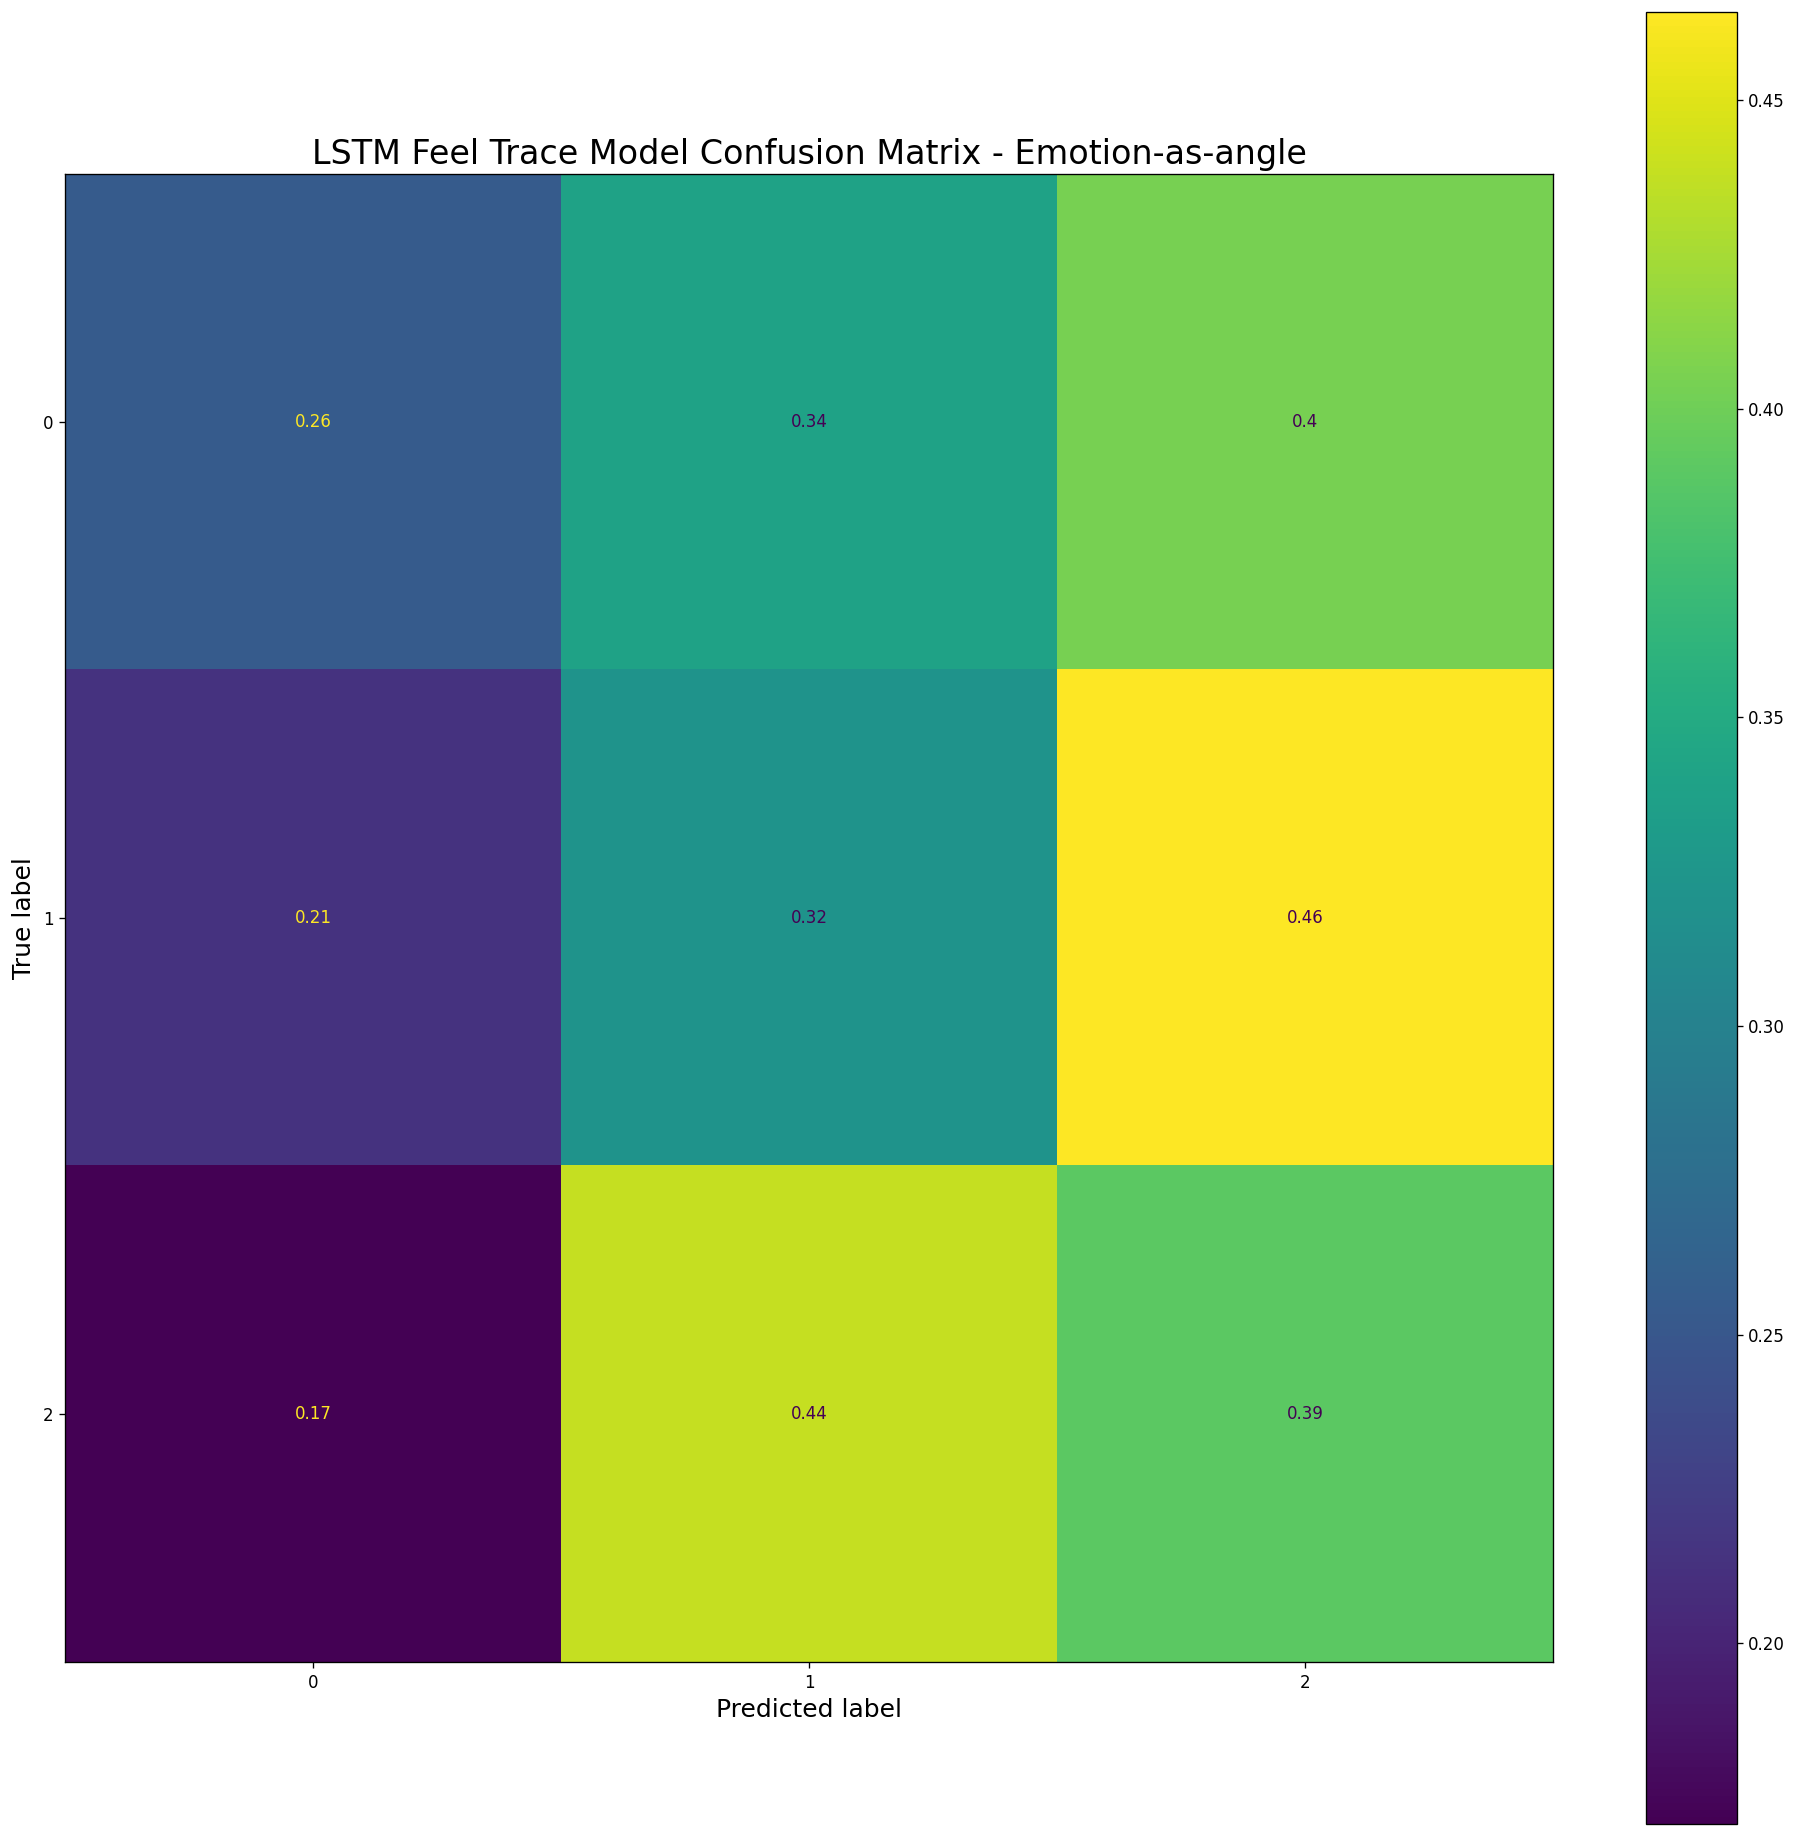

Training k=3
Training Classifier!
Train label distribution: [190 447 164]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch:1,
Train Loss:1.1925941705703735,
Train Accuracy:0.35802218614718617,
Train Recall: 0.330777372374011,
Train precision: 0.2141794502346295,
Train F1-Score:0.21128986443237827,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:2,
Train Loss:1.1078485250473022,
Train Accuracy:0.34422348484848486,
Train Recall: 0.338206030772476,
Train precision: 0.2342413933465362,
Train F1-Score:0.21622815955184518,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:3,
Train Loss:1.0970993041992188,
Train Accuracy:0.3698931277056277,
Train Recall: 0.3617556484223031,
Train precision: 0.34428026688013524,
Train F1-Score:0.27878864024459127,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:4,
Train Loss:1.0875054597854614,
Train Accuracy:0.4043560606060606,
Train Recall: 0.415147671456181,
Train precision: 0.44606451026713406,
Train F1-Score:0.3549331949865338,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:5,
Train Loss:1.0841566324234009,
Train Accuracy:0.41971049783549785,
Train Recall: 0.426202926109613,
Train precision: 0.42128625876216147,
Train F1-Score:0.39935377560302104,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:6,
Train Loss:1.0783756971359253,
Train Accuracy:0.42752299783549785,
Train Recall: 0.438995643410032,
Train precision: 0.48450753416988074,
Train F1-Score:0.3820533527435285,


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch:7,
Train Loss:1.0534415245056152,
Train Accuracy:0.4718952922077922,
Train Recall: 0.4772248640772744,
Train precision: 0.4814635635280555,
Train F1-Score:0.4622255554785855,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:8,
Train Loss:1.0337387323379517,
Train Accuracy:0.45850243506493504,
Train Recall: 0.44867596873987153,
Train precision: 0.45977269691152384,
Train F1-Score:0.4324938799611764,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:9,
Train Loss:1.0523948669433594,
Train Accuracy:0.43016098484848486,
Train Recall: 0.4321096051171675,
Train precision: 0.45727956726132446,
Train F1-Score:0.41105879615348234,


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Epoch:10,
Train Loss:1.027023434638977,
Train Accuracy:0.4856939935064935,
Train Recall: 0.4734571255419883,
Train precision: 0.49968491080343125,
Train F1-Score:0.46265110300914053,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:11,
Train Loss:0.9894947409629822,
Train Accuracy:0.49631358225108224,
Train Recall: 0.49009274307796746,
Train precision: 0.5066006792533205,
Train F1-Score:0.4823466693653055,


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch:12,
Train Loss:0.9860787987709045,
Train Accuracy:0.5010484307359307,
Train Recall: 0.4921126108750658,
Train precision: 0.5089380028097706,
Train F1-Score:0.48323918445073005,


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch:13,
Train Loss:0.9746662378311157,
Train Accuracy:0.5321631493506493,
Train Recall: 0.5316199104303105,
Train precision: 0.5361471415501562,
Train F1-Score:0.520617540738661,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:14,
Train Loss:0.9447652101516724,
Train Accuracy:0.572071158008658,
Train Recall: 0.5745478803139213,
Train precision: 0.5753283066430211,
Train F1-Score:0.5628963724795102,


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch:15,
Train Loss:0.9136009216308594,
Train Accuracy:0.5896577380952381,
Train Recall: 0.579930730720008,
Train precision: 0.6157184132816437,
Train F1-Score:0.5669591674690239,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:16,
Train Loss:0.9367923736572266,
Train Accuracy:0.5823863636363635,
Train Recall: 0.5828343193908383,
Train precision: 0.6057036318187421,
Train F1-Score:0.5720283126782568,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:17,
Train Loss:0.8600063323974609,
Train Accuracy:0.5963541666666667,
Train Recall: 0.5868256755435401,
Train precision: 0.5924666955852068,
Train F1-Score:0.581729910199779,


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch:18,
Train Loss:0.8585428595542908,
Train Accuracy:0.593952922077922,
Train Recall: 0.5964650877725814,
Train precision: 0.6052734255132772,
Train F1-Score:0.5906689703205906,


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch:19,
Train Loss:0.8735038042068481,
Train Accuracy:0.5952042748917749,
Train Recall: 0.5994224560220751,
Train precision: 0.600356174616772,
Train F1-Score:0.5904436554999938,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:20,
Train Loss:0.8085788488388062,
Train Accuracy:0.6405573593073594,
Train Recall: 0.6369370126164033,
Train precision: 0.649675092779195,
Train F1-Score:0.6237257122618173,


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch:21,
Train Loss:0.8194134831428528,
Train Accuracy:0.6389001623376623,
Train Recall: 0.6459465359267494,
Train precision: 0.6668640405505347,
Train F1-Score:0.6340490503312445,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:22,
Train Loss:0.7969359159469604,
Train Accuracy:0.6436350108225108,
Train Recall: 0.6467854487300363,
Train precision: 0.673468796852385,
Train F1-Score:0.6395248854862642,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:23,
Train Loss:0.7926551699638367,
Train Accuracy:0.6589894480519481,
Train Recall: 0.6492611936647078,
Train precision: 0.6546851964829814,
Train F1-Score:0.6411697637474637,


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch:24,
Train Loss:0.7509637475013733,
Train Accuracy:0.6958198051948052,
Train Recall: 0.6890430192949631,
Train precision: 0.6926506538418218,
Train F1-Score:0.6801863260176363,


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Epoch:25,
Train Loss:0.7379439473152161,
Train Accuracy:0.6744791666666667,
Train Recall: 0.6757520732306034,
Train precision: 0.6777119564147637,
Train F1-Score:0.6692671207945408,


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch:26,
Train Loss:0.6438965201377869,
Train Accuracy:0.7441152597402597,
Train Recall: 0.7433110136133668,
Train precision: 0.7434896224668949,
Train F1-Score:0.7393194473773747,


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch:27,
Train Loss:0.6173601150512695,
Train Accuracy:0.7431344696969697,
Train Recall: 0.7443944274698008,
Train precision: 0.7545164651856661,
Train F1-Score:0.7373295049384962,


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch:28,
Train Loss:0.6229801177978516,
Train Accuracy:0.7428300865800866,
Train Recall: 0.7382669372971217,
Train precision: 0.745346392289088,
Train F1-Score:0.736850062491147,


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch:29,
Train Loss:0.5810771584510803,
Train Accuracy:0.772558170995671,
Train Recall: 0.7735100700048083,
Train precision: 0.7736033706921096,
Train F1-Score:0.7715931174359522,


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Epoch:30,
Train Loss:0.5887333154678345,
Train Accuracy:0.7841585497835498,
Train Recall: 0.7867367406343939,
Train precision: 0.7907945848123242,
Train F1-Score:0.7819399713608541,
Test label distribution: [ 47 112  41]
Precision: 0.3771341082364705
Recall: 0.3636342575431833
F1-Score: 0.3663816627251228
Base line F1-Score: 0.23931623931623933
Accuracy: 0.45
Metrics:
              precision    recall  f1-score   support

           0       0.27      0.26      0.26        47
           1       0.54      0.62      0.58       112
           2       0.32      0.22      0.26        41

    accuracy                           0.45       200
   macro avg       0.38      0.36      0.37       200
weighted avg       0.43      0.45      0.44       200



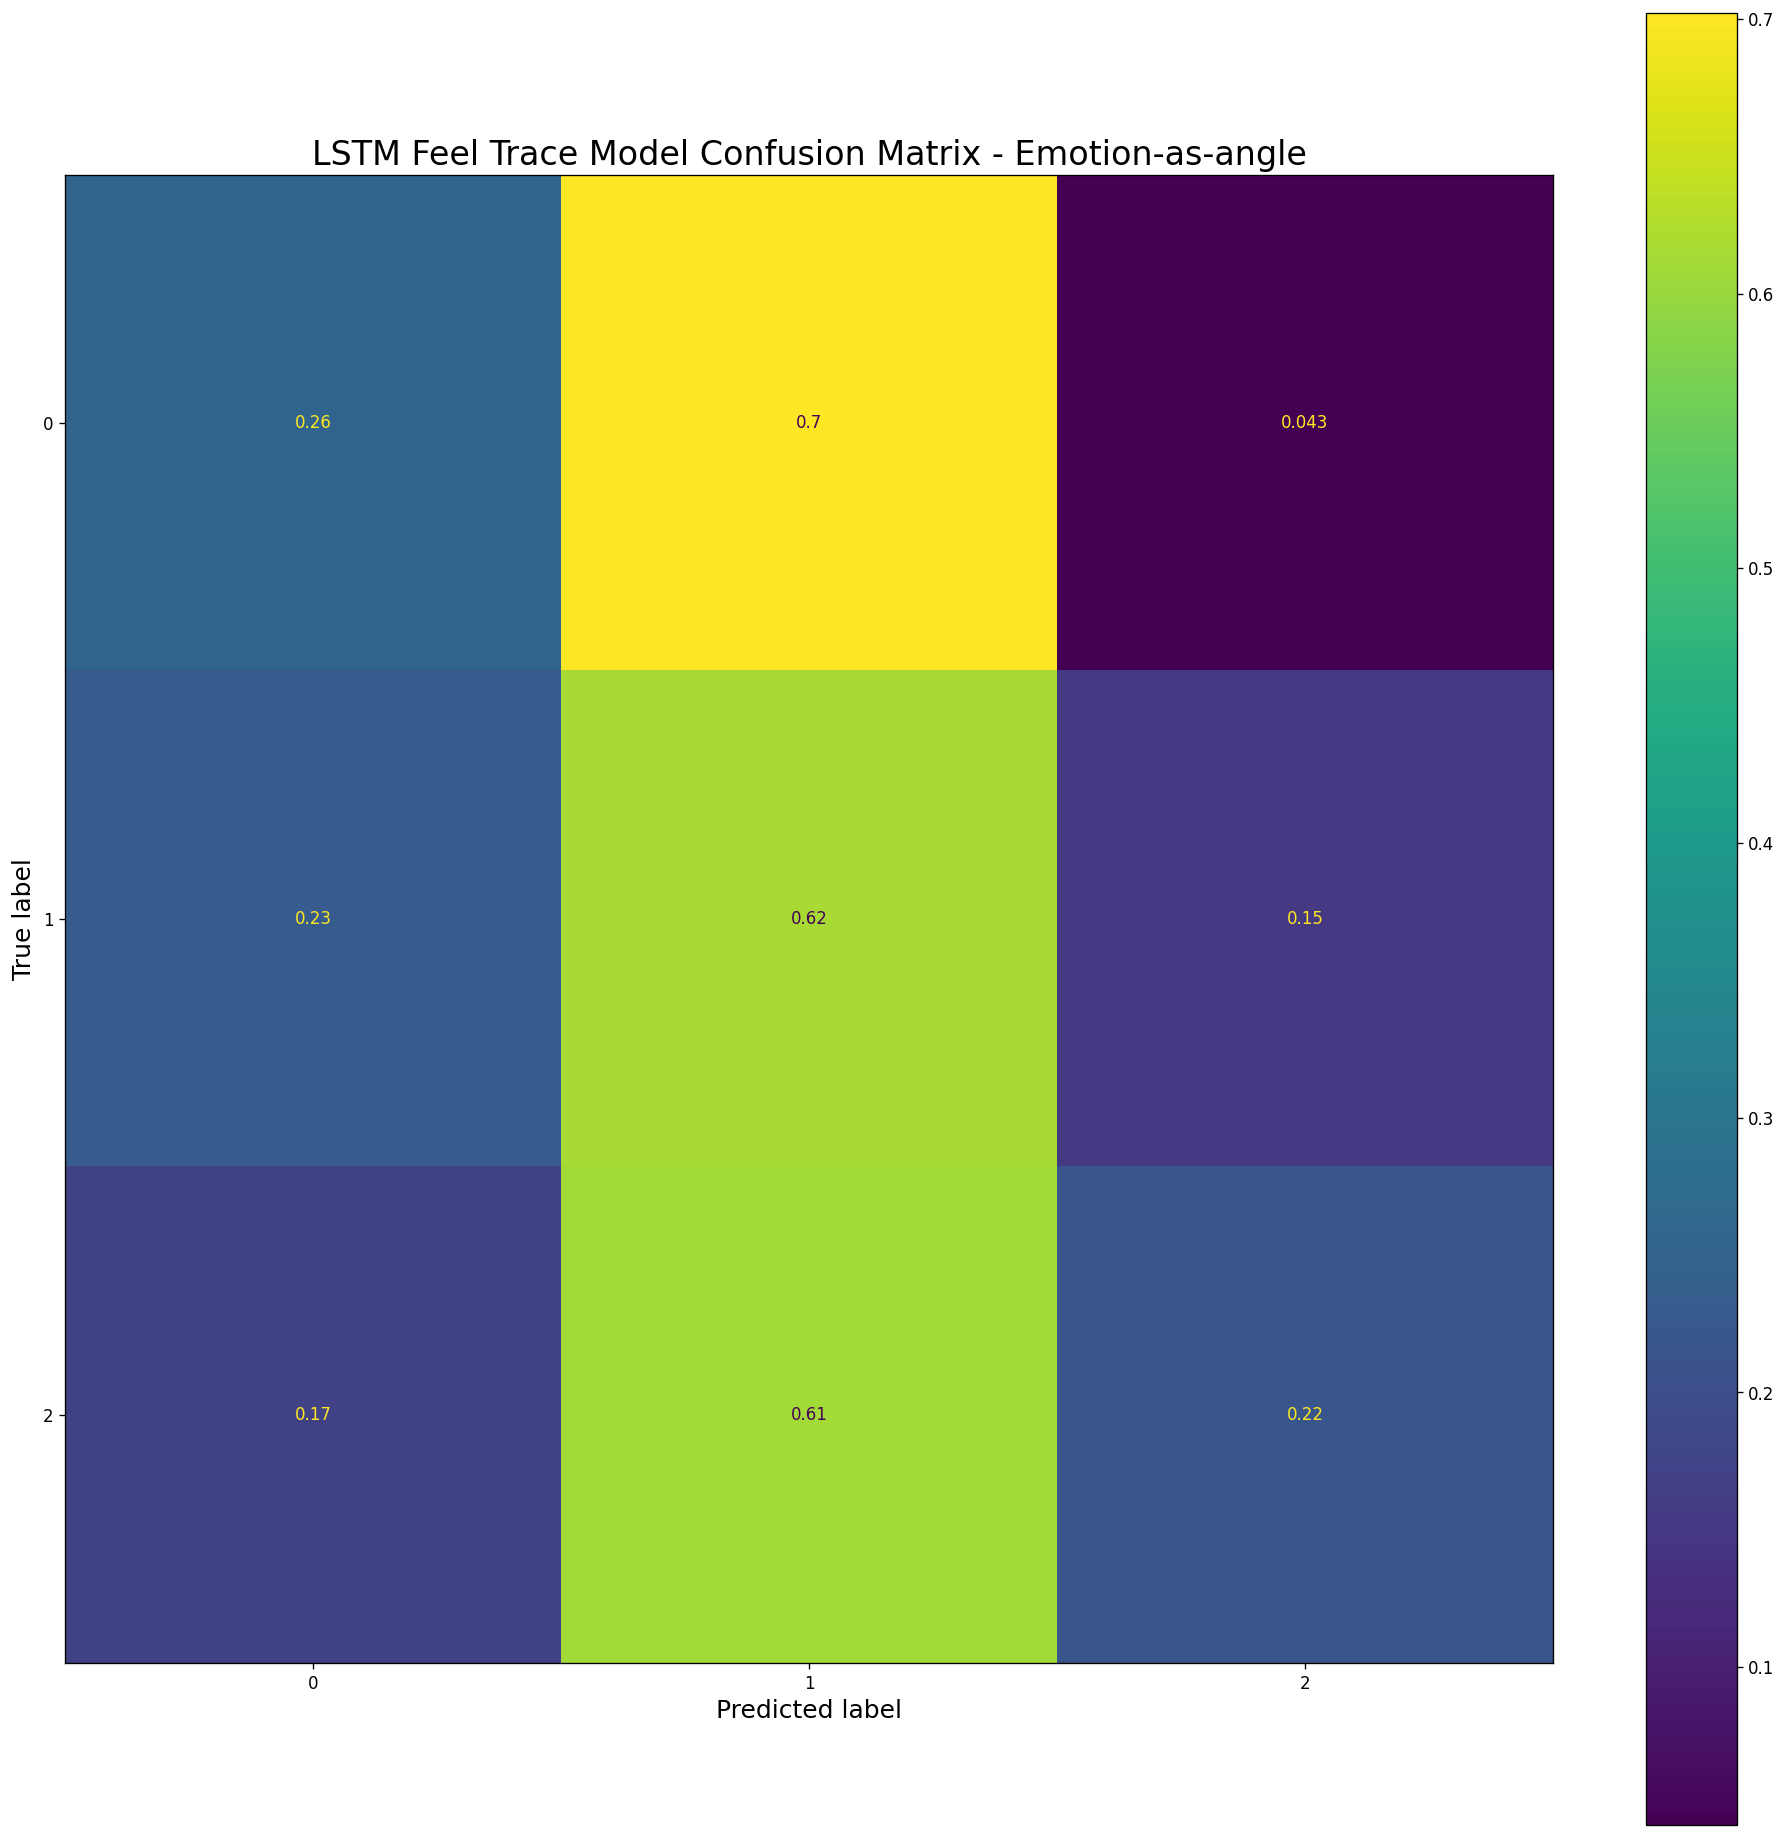

Training k=4
Training Classifier!
Train label distribution: [189 448 164]


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:1,
Train Loss:1.4406015872955322,
Train Accuracy:0.3523065476190476,
Train Recall: 0.32907554854883286,
Train precision: 0.19054906295422128,
Train F1-Score:0.22228556978948436,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:2,
Train Loss:1.1224430799484253,
Train Accuracy:0.34239718614718617,
Train Recall: 0.335640411797704,
Train precision: 0.1533949571157529,
Train F1-Score:0.1949380659715652,


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch:3,
Train Loss:1.1064239740371704,
Train Accuracy:0.34561011904761907,
Train Recall: 0.33111361255377475,
Train precision: 0.1703808581238259,
Train F1-Score:0.19472549304399278,


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch:4,
Train Loss:1.102259874343872,
Train Accuracy:0.35788690476190477,
Train Recall: 0.3407070841066135,
Train precision: 0.24705830561566583,
Train F1-Score:0.1994974138685436,


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Epoch:5,
Train Loss:1.0975573062896729,
Train Accuracy:0.339353354978355,
Train Recall: 0.34185244568539697,
Train precision: 0.24342894554239078,
Train F1-Score:0.21422790131063216,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:6,
Train Loss:1.101685643196106,
Train Accuracy:0.3548430735930736,
Train Recall: 0.3427214794248087,
Train precision: 0.18638682078226884,
Train F1-Score:0.20048974692677937,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:7,
Train Loss:1.0987520217895508,
Train Accuracy:0.32186823593073594,
Train Recall: 0.33418476382769785,
Train precision: 0.37306276504198016,
Train F1-Score:0.273797701670172,


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch:8,
Train Loss:1.0951781272888184,
Train Accuracy:0.3747632575757576,
Train Recall: 0.3772314352389894,
Train precision: 0.39079152734907474,
Train F1-Score:0.3600547315109023,


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch:9,
Train Loss:1.0926847457885742,
Train Accuracy:0.3421266233766234,
Train Recall: 0.35110790039203366,
Train precision: 0.36941621973563393,
Train F1-Score:0.2868142312026444,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:10,
Train Loss:1.0919737815856934,
Train Accuracy:0.35257711038961037,
Train Recall: 0.35950057609955755,
Train precision: 0.3184327458058353,
Train F1-Score:0.27294063872327445,


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch:11,
Train Loss:1.0872541666030884,
Train Accuracy:0.38832521645021645,
Train Recall: 0.3519618175288887,
Train precision: 0.33468228565689717,
Train F1-Score:0.2867729652273931,


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch:12,
Train Loss:1.102603554725647,
Train Accuracy:0.3322172619047619,
Train Recall: 0.36058167010547965,
Train precision: 0.310462719222054,
Train F1-Score:0.2227934312665604,


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Epoch:13,
Train Loss:1.0931462049484253,
Train Accuracy:0.36123511904761907,
Train Recall: 0.35431231614627695,
Train precision: 0.37720932092532916,
Train F1-Score:0.26770186177704813,


100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


Epoch:14,
Train Loss:1.078106164932251,
Train Accuracy:0.4322578463203463,
Train Recall: 0.4143443432086232,
Train precision: 0.40416896737892244,
Train F1-Score:0.37783466064015875,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:15,
Train Loss:1.0806246995925903,
Train Accuracy:0.40073728354978355,
Train Recall: 0.3783376642416925,
Train precision: 0.3316998990365537,
Train F1-Score:0.27214073373105385,


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch:16,
Train Loss:1.0823825597763062,
Train Accuracy:0.38132440476190477,
Train Recall: 0.4009473520873309,
Train precision: 0.26270873765260877,
Train F1-Score:0.3062474229187763,


100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


Epoch:17,
Train Loss:1.0741589069366455,
Train Accuracy:0.3997564935064935,
Train Recall: 0.412255953944707,
Train precision: 0.36626808780526837,
Train F1-Score:0.35400608403757267,


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch:18,
Train Loss:1.0852142572402954,
Train Accuracy:0.3835565476190476,
Train Recall: 0.39689767592591385,
Train precision: 0.4461331799609322,
Train F1-Score:0.34283342921351956,


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch:19,
Train Loss:1.0683813095092773,
Train Accuracy:0.41328463203463206,
Train Recall: 0.41600938831919,
Train precision: 0.4332599477176449,
Train F1-Score:0.39142307984807406,


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch:20,
Train Loss:1.0643281936645508,
Train Accuracy:0.4298904220779221,
Train Recall: 0.4460705769604952,
Train precision: 0.4759769977508901,
Train F1-Score:0.4041779677887759,


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch:21,
Train Loss:1.0682777166366577,
Train Accuracy:0.440915854978355,
Train Recall: 0.4475690665924555,
Train precision: 0.4398483813740911,
Train F1-Score:0.4170174570742451,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:22,
Train Loss:1.033694863319397,
Train Accuracy:0.48346185064935066,
Train Recall: 0.4778527604526913,
Train precision: 0.50960659557659,
Train F1-Score:0.44896002096314985,


100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch:23,
Train Loss:1.05071222782135,
Train Accuracy:0.42109713203463206,
Train Recall: 0.4319877785260493,
Train precision: 0.47347381894803775,
Train F1-Score:0.3633130591197805,


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch:24,
Train Loss:1.0321811437606812,
Train Accuracy:0.46323728354978355,
Train Recall: 0.468133084598274,
Train precision: 0.4649367772598782,
Train F1-Score:0.4561002155510434,


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch:25,
Train Loss:1.0302437543869019,
Train Accuracy:0.46952786796536794,
Train Recall: 0.4690076907848009,
Train precision: 0.462813982198271,
Train F1-Score:0.4477444580035415,


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Epoch:26,
Train Loss:1.000909447669983,
Train Accuracy:0.5305059523809523,
Train Recall: 0.518139954946276,
Train precision: 0.5262947230355242,
Train F1-Score:0.47786608802218317,


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch:27,
Train Loss:1.0275100469589233,
Train Accuracy:0.47426271645021645,
Train Recall: 0.46784969459339937,
Train precision: 0.4642221589882354,
Train F1-Score:0.3931751960110971,


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch:28,
Train Loss:1.0280743837356567,
Train Accuracy:0.4751082251082251,
Train Recall: 0.4815153091006675,
Train precision: 0.487916975139267,
Train F1-Score:0.40618379974781965,


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch:29,
Train Loss:1.0141494274139404,
Train Accuracy:0.48542343073593075,
Train Recall: 0.49057008050120166,
Train precision: 0.49744550976763696,
Train F1-Score:0.4711077598200735,


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch:30,
Train Loss:0.9945160746574402,
Train Accuracy:0.49739583333333337,
Train Recall: 0.5103667435869567,
Train precision: 0.4999103358477752,
Train F1-Score:0.48999813890343347,
Test label distribution: [ 48 111  41]
Precision: 0.3594743716507367
Recall: 0.36031458287555845
F1-Score: 0.3498477316165867
Base line F1-Score: 0.23794212218649516
Accuracy: 0.38
Metrics:
              precision    recall  f1-score   support

           0       0.30      0.29      0.29        48
           1       0.57      0.42      0.48       111
           2       0.21      0.37      0.27        41

    accuracy                           0.38       200
   macro avg       0.36      0.36      0.35       200
weighted avg       0.43      0.38      0.40       200



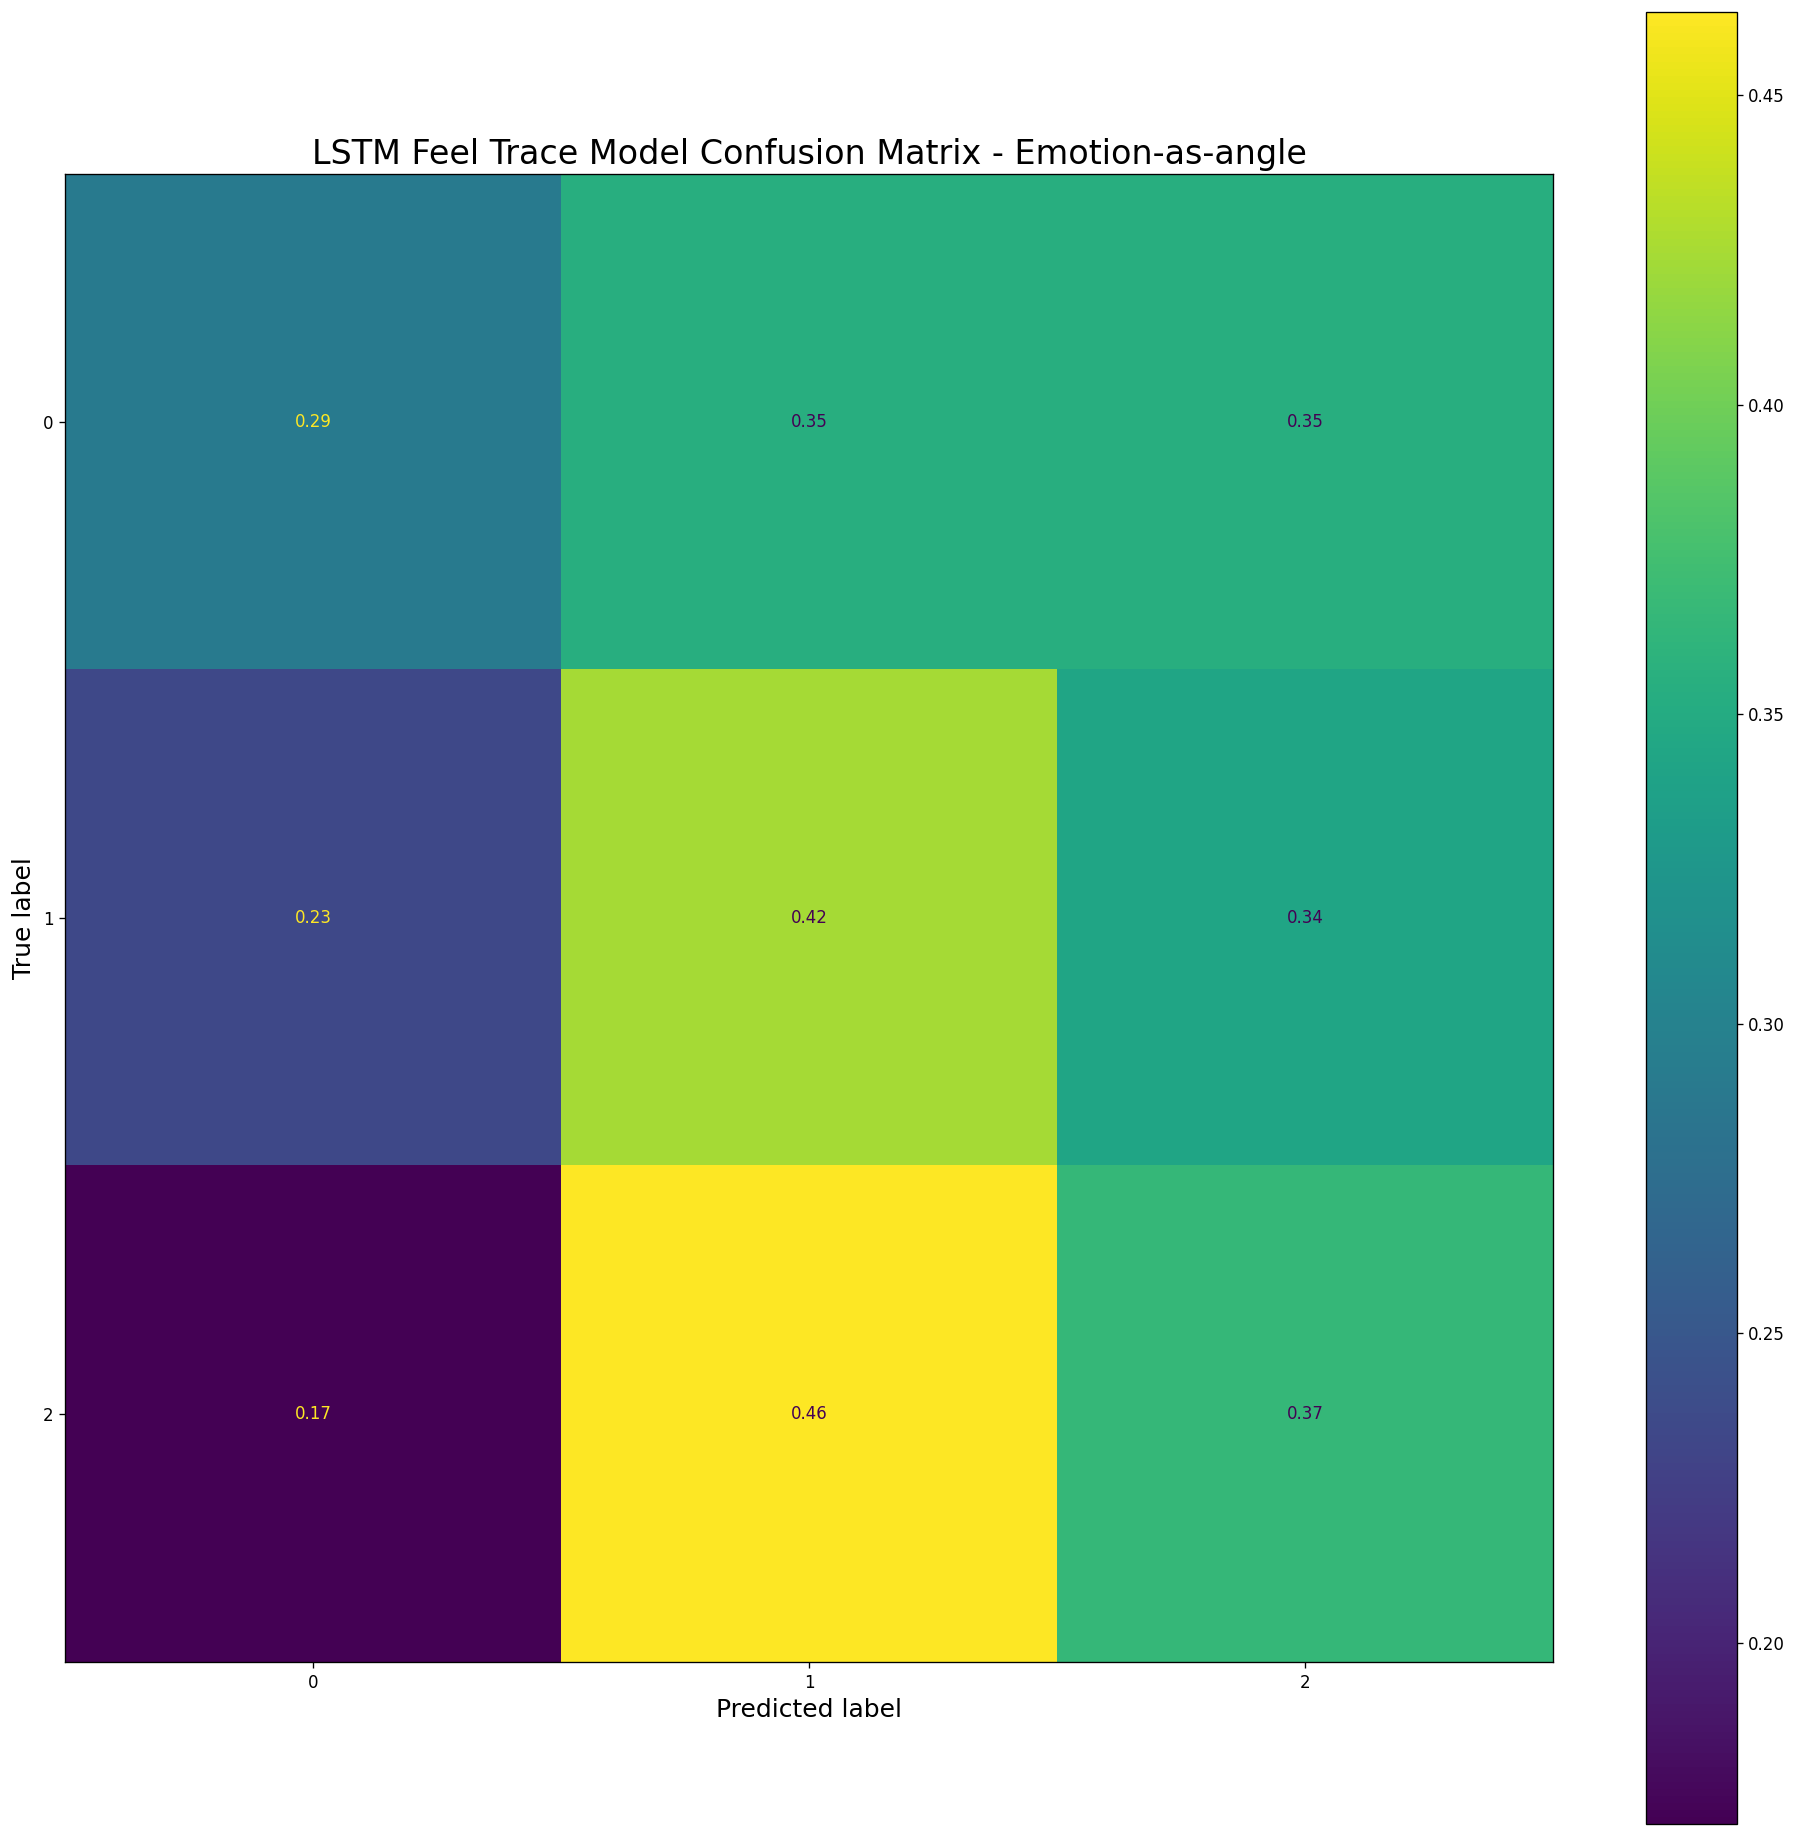

Accuracy, Average accuracy: [0.41400503290747187, 0.354727308671263, 0.3223305409345887, 0.3636342575431833, 0.36031458287555845], 0.36300234458641306
F1-Score, Average F1-Score: [0.3997860957244958, 0.3456360708534622, 0.30409035409035406, 0.3663816627251228, 0.3498477316165867], 0.3531483830020043


In [17]:
k_acc = [] # accuracies for each fold
k_f1 = [] # f1 score for each fold

for cur_k in range(len(indices)):
    print(f"Training k={cur_k}")
    train_index, test_index = indices[cur_k]

    classifier_model = classifier(num_features=num_features, num_hidden=classifier_hidden, dropout=0.8, n_labels=num_classes)


    encoded_train_features = eeg_features[train_index]
    print('Training Classifier!')
    classifier_train_metrics = train_classifier(classifier_model, classifier_train_epochs, batch_size=128, learning_rate=classifier_learning_rate, features=encoded_train_features, labels=labels[train_index])


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_features, test_labels =  eeg_features[test_index], labels[test_index]
    print(f"Test label distribution: {np.bincount(test_labels, minlength=num_classes)}")
    encoded_test_features = test_features

    with torch.no_grad():
        classifier_model.eval()
        x_encoded  = torch.from_numpy(encoded_test_features).float().to(device)
        y = test_labels
        y_hat = classifier_model(x_encoded)
        y_hat = F.softmax(y_hat.detach(), dim=-1).cpu().numpy()
        preds = y_hat

    fig, axs = plt.subplots(figsize=(20,20), dpi=120)
    axs.set_title(f"LSTM Feel Trace Model Confusion Matrix - Emotion-as-{label_type}", fontsize=20)
    axs.set_xlabel("Predicted Label", fontsize=15)
    axs.set_ylabel("True Label", fontsize=15)


    prf = precision_recall_fscore_support(test_labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
    base_line = precision_recall_fscore_support(test_labels, np.array([1 for x in preds]), average='macro', zero_division=0)
    acc = np.mean(test_labels == np.array([x.argmax() for x in preds]))

    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F1-Score: {prf[2]}")
    print(f"Base line F1-Score: {base_line[2]}")
    print(f"Accuracy: {acc}")
    print('Metrics:')
    print(classification_report(test_labels, np.array([x.argmax() for x in preds])))


    cm = confusion_matrix(test_labels, [x.argmax() for x in preds], labels=np.arange(num_classes), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
    
    acc = np.mean(cm.diagonal())
    k_acc.append(acc)
    k_f1.append(prf[2])


    disp.plot(ax=axs)
    plt.show()

print(f"Accuracy, Average accuracy: {k_acc}, {np.mean(k_acc)}")
print(f"F1-Score, Average F1-Score: {k_f1}, {np.mean(k_f1)}")